In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2, l1_l2
import matplotlib.pyplot as plt

/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-24 17:34:20.170495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748118860.290453 2702728 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748118860.320573 2702728 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748118860.559027 2702728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W

# Tratamento dos Dados

In [ ]:
df = pd.read_csv('../dataset_fz_cz.csv')

df

In [ ]:
fft_columns = df.iloc[:, :1500]
def safe_complex(x):
    try:
        return complex(x)
    except (ValueError, TypeError):
        return np.nan
fft_complex = fft_columns.map(safe_complex)
df.iloc[:, :1500] = fft_complex

## Separando X e Y

In [ ]:
y = df['classe']
X = df.drop(['classe','voluntario'], axis=1)

In [ ]:
X

In [ ]:
y.value_counts()

## Divisão em conjunto de Treino e Teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train_rec_f0 = X_train.iloc[:, :500]
X_test_rec_f0 = X_test.iloc[:, :500]

In [ ]:
X_train.iloc[:,:1500] = X_train.iloc[:,:1500].map(lambda x: np.abs(x))
X_test.iloc[:,:1500] = X_test.iloc[:,:1500].map(lambda x: np.abs(x))

In [ ]:
X_train.shape, X_test.shape

In [ ]:
X_train

In [ ]:
indice_f0 = list(range(500)) + [1500] + list(range(1503, X_train.shape[1]))
X_train_f0 = X_train.iloc[:, indice_f0]
X_test_f0 = X_test.iloc[:, indice_f0]

In [ ]:
indice_h2 = list(range(1000)) + [1500, 1501] + list(range(1503, X_train.shape[1]))
X_train_h2 = X_train.iloc[:, indice_h2]
X_test_h2 = X_test.iloc[:, indice_h2]

## Codificar Variáveis Categóricas

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_columns = ['Faixa_Moduladora', 
                     'Intensidade_db', 
                     'Canal']

numerical_columns = ['Freq_analisada_Hz']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

X_train_f0 = preprocessor.fit_transform(X_train_f0)
X_test_f0 = preprocessor.transform(X_test_f0)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_columns = ['Faixa_Moduladora', 
                     'Intensidade_db', 
                     'Canal']

numerical_columns = ['Freq_analisada_Hz', 'Freq_h2_analisada_Hz',]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

X_train_h2 = preprocessor.fit_transform(X_train_h2)
X_test_h2 = preprocessor.transform(X_test_h2)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_columns = ['Faixa_Moduladora', 
                     'Intensidade_db', 
                     'Canal']

numerical_columns = ['Freq_analisada_Hz', 
                     'Freq_h2_analisada_Hz',
                     'Freq_h3_analisada_Hz']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Com o ColumnTransformer, as colunas após o pré-processamento podem ter nomes alterados (ex.: Faixa_40, Faixa_80). 

In [ ]:
colunas_processadas = preprocessor.get_feature_names_out()

In [ ]:
colunas_processadas

In [ ]:
pd.DataFrame(X_train).head()

In [ ]:
X_train

In [ ]:
pd.DataFrame(X_train).to_parquet('f0_h2_h3/X_train.parquet', index=False)
pd.DataFrame(X_test).to_parquet('f0_h2_h3/X_test.parquet', index=False)
pd.DataFrame(y_train).to_parquet('f0_h2_h3/y_train.parquet', index=False)
pd.DataFrame(y_test).to_parquet('f0_h2_h3/y_test.parquet', index=False)

In [ ]:
X_train_rec_f0.to_csv('f0/X_train_rec_f0.csv', index=False)
X_test_rec_f0.to_csv('f0/X_test_rec_f0.csv', index=False)

In [ ]:
pd.DataFrame(X_train_f0).to_parquet('f0/X_train_f0.parquet', index=False)
pd.DataFrame(X_test_f0).to_parquet('f0/X_test_f0.parquet', index=False)
pd.DataFrame(y_train).to_parquet('f0/y_train_f0.parquet', index=False)
pd.DataFrame(y_test).to_parquet('f0/y_test_f0.parquet', index=False)

In [ ]:
pd.DataFrame(X_train_h2).to_parquet('f0_h2/X_train_h2.parquet', index=False)
pd.DataFrame(X_test_h2).to_parquet('f0_h2/X_test_h2.parquet', index=False)
pd.DataFrame(y_train).to_parquet('f0_h2/y_train_h2.parquet', index=False)
pd.DataFrame(y_test).to_parquet('f0_h2/y_test_h2.parquet', index=False)

Até aqui, foi realizado a separação do X e Y, nos quais foram separados em conjunto de teste e treinamento. Além disso, os conjuntos de treino para os modelos de ML foram transformados para pegar apenas os módulos, já os em formato retangular, será utilizado na CSM e MSC. Obtendo assim, 4 datasets finais

# Desenvolvimento dos Modelos

## Carregando os Dados

In [3]:
X_train_f0 = pd.read_parquet('f0/X_train_f0.parquet')
X_test_f0 = pd.read_parquet('f0/X_test_f0.parquet')
y_train_f0 = pd.read_parquet('f0/y_train_f0.parquet')
y_test_f0 = pd.read_parquet('f0/y_test_f0.parquet')

In [4]:
X_train_h2 = pd.read_parquet('f0_h2/X_train_h2.parquet')
X_test_h2 = pd.read_parquet('f0_h2/X_test_h2.parquet')
y_train_h2 = pd.read_parquet('f0_h2/y_train_h2.parquet')
y_test_h2 = pd.read_parquet('f0_h2/y_test_h2.parquet')

In [5]:
X_train = pd.read_parquet('f0_h2_h3/X_train.parquet')
X_test = pd.read_parquet('f0_h2_h3/X_test.parquet')
y_train = pd.read_parquet('f0_h2_h3/y_train.parquet')
y_test = pd.read_parquet('f0_h2_h3/y_test.parquet')

In [6]:
datasets = {
    'Fundamental': {
        'X_train': X_train_f0,
        'y_train': y_train_f0,
        'X_test': X_test_f0,
        'y_test': y_test_f0
    },
    'Fundamental + 2º Harmônico': {
        'X_train': X_train_h2,
        'y_train': y_train_h2,
        'X_test': X_test_h2,
        'y_test': y_test_h2
    },
    'Fundamental + 2º + 3º Harmônicos': {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
}

## Criando o modelo RNA

### RNA Padrão

In [ ]:
def create_model(trial, input_shape):
    n_layers = trial.suggest_int('n_layers', 1, 50)
    units = trial.suggest_int('units', 32, 512, step=32)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for i in range(n_layers):
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

### RNA variando parametros por camada

In [ ]:
def create_model_layer(trial, input_shape):
    n_layers = trial.suggest_int('n_layers', 1, 20)
    units = []
    dropouts = []

    for i in range(n_layers):
        units.append(trial.suggest_int(f'units_{i}', 32, 512, step=32))
        dropouts.append(trial.suggest_float(f'dropout_{i}', 0.0, 0.5))

    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    l2_weight = trial.suggest_float('l2_weight', 1e-5, 1e-2, log=True)
    l1_weight = trial.suggest_float('l1_weight', 1e-5, 1e-2, log=True)
    
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    for i in range(n_layers):
        model.add(layers.Dense(units[i], activation='relu', kernel_regularizer=l1_l2(l1=l1_weight, l2=l2_weight)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropouts[i]))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

## RNA + LSTM

In [7]:
def create_sequence(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length - 1])
    return np.array(X), np.array(y)

X_train_f0_seq, y_train_f0_seq = create_sequence(X_train_f0.values, y_train_f0.values, 20)
X_test_f0_seq, y_test_f0_seq = create_sequence(X_test_f0.values, y_test_f0.values, 20)

X_train_h2_seq, y_train_h2_seq = create_sequence(X_train_h2.values, y_train_h2.values, 20)
X_test_h2_seq, y_test_h2_seq = create_sequence(X_test_h2.values, y_test_h2.values, 20)

X_train_seq, y_train_seq = create_sequence(X_train.values, y_train.values, 20)
X_test_seq, y_test_seq = create_sequence(X_test.values, y_test.values, 20)
        

In [8]:
datasets_seq = {
    'Fundamental': {
        'X_train': X_train_f0_seq,
        'y_train': y_train_f0_seq,
        'X_test': X_test_f0_seq,
        'y_test': y_test_f0_seq
    },
    'Fundamental + 2º Harmônico': {
        'X_train': X_train_h2_seq,
        'y_train': y_train_h2_seq,
        'X_test': X_test_h2_seq,
        'y_test': y_test_h2_seq
    },
    'Fundamental + 2º + 3º Harmônicos': {
        'X_train': X_train_seq,
        'y_train': y_train_seq,
        'X_test': X_test_seq,
        'y_test': y_test_seq
    }
}

In [9]:
def create_lstm_model(trial, input_shape):
    # Hiperparâmetros para LSTM
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
    lstm_units = [trial.suggest_int(f'lstm_units_{i}', 32, 256) for i in range(n_lstm_layers)]
    lstm_dropout = [trial.suggest_float(f'lstm_dropout_{i}', 0.0, 0.5) for i in range(n_lstm_layers)]
    
    # Hiperparâmetros para Dense
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 50)
    dense_units = [trial.suggest_int(f'dense_units_{i}', 32, 512) for i in range(n_dense_layers)]
    dense_dropout = [trial.suggest_float(f'dense_dropout_{i}', 0.0, 0.5) for i in range(n_dense_layers)]
    
    # Construção do modelo
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))  # (look_back, n_features)
    
    # Camadas LSTM
    for i in range(n_lstm_layers):
        return_sequences = (i < n_lstm_layers - 1)  # Retorna sequências se não for a última camada
        model.add(layers.LSTM(
            lstm_units[i],
            return_sequences=return_sequences,
            kernel_regularizer=l2(trial.suggest_float('l2_weight', 1e-5, 1e-2))
        ))
        model.add(layers.Dropout(lstm_dropout[i]))
    
    # Camadas Densas
    for i in range(n_dense_layers):
        model.add(layers.Dense(dense_units[i], activation='relu'))
        model.add(layers.Dropout(dense_dropout[i]))
    
    # Saída
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilar
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

## Optuna

### Função Objetiva para todas as frequências

In [10]:
def objective(trial, X_train, y_train):
    input_shape = X_train.shape[1:]

    model = create_lstm_model(trial, input_shape) #Mudar se quer RNA ou RNA + LSTM
    y_train = y_train.squeeze().astype(int)
    
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight = {i: w for i, w in zip(classes, class_weights)}

    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=30,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=20,
        mode='max',
        min_lr=1e-7,
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        validation_split=0.1,
        callbacks=[callback, lr_scheduler],
        verbose=1,
        class_weight=class_weight
    )


    best_auc = max(history.history['val_auc'])

    return best_auc


### Treinando Modelo com os melhores hiperparametros - RNA

In [ ]:
def build_final_model(best_params, input_shape):
    n_layers = best_params['n_layers']
    units = best_params['units']
    dropout = best_params['dropout']
    learning_rate = best_params['learning_rate']
   
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for i in range(n_layers):
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def build_final_model_layer(best_params, input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # Extrai hiperparâmetros por camada
    n_layers = best_params['n_layers']
    units = [best_params[f'units_{i}'] for i in range(n_layers)]
    dropouts = [best_params[f'dropout_{i}'] for i in range(n_layers)]
    
    # Constrói as camadas
    for i in range(n_layers):
        model.add(layers.Dense(units[i], activation='relu', kernel_regularizer=l1_l2(l1=best_params['l1_weight'], l2=best_params['l2_weight'])))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropouts[i]))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [11]:
def build_final_model_lstm(best_params, input_shape):
    
    n_lstm_layers = best_params['n_lstm_layers']
    lstm_dropout = [best_params[f'lstm_dropout_{i}'] for i in range(n_lstm_layers)]
    lstm_units = [best_params[f'lstm_units_{i}'] for i in range(n_lstm_layers)]
    
    n_dense_layers = best_params['n_dense_layers']
    dense_units = [best_params[f'dense_units_{i}'] for i in range(n_dense_layers)]
    dense_dropout = [best_params[f'dense_dropout_{i}'] for i in range(n_dense_layers)]
    
    # Construção do modelo
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))  # (look_back, n_features)
    
    # Camadas LSTM
    for i in range(n_lstm_layers):
        return_sequences = (i < n_lstm_layers - 1)  # Retorna sequências se não for a última camada
        model.add(layers.LSTM(
            lstm_units[i],
            return_sequences=return_sequences,
            kernel_regularizer=l2(best_params['l2_weight'])
        ))
        model.add(layers.Dropout(lstm_dropout[i]))
    
    # Camadas Densas
    for i in range(n_dense_layers):
        model.add(layers.Dense(dense_units[i], activation='relu'))
        model.add(layers.Dropout(dense_dropout[i]))
    
    # Saída
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilar
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

#### Resultados

In [12]:
from sklearn.metrics import roc_curve, auc, classification_report

def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_prob = model.predict(X_test).ravel()

    # AUC e FPR
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Encontre o threshold ótimo (maximiza TPR - FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    y_test_1d = y_test.squeeze()
    y_pred = (y_prob > optimal_threshold).astype(int)
    
    # Métricas
    print(classification_report(y_test_1d, y_pred))
    print(pd.crosstab(y_test_1d, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))
    print(f'AUC: {roc_auc:.4f}')
    print(f'Threshold ótimo: {optimal_threshold:.4f}')
    
    return roc_auc, optimal_threshold, fpr, tpr

In [13]:
results = {}

N_TRIALS = 150

for dataset_name, data in datasets_seq.items(): #datasets_seq.items(): se for LSTM
    print(f'\n=== Processando {dataset_name} ===')

    #study_name = f'tcc_auc_all_features_{dataset_name.replace(" ", "_")}_v5'
    study_name = f'tcc_auc_all_features_{dataset_name.replace(" ", "_")}_lstm_v2'
    storage = 'sqlite:///../tcc.db'
    model_path = f'models/{study_name}.keras'

    if os.path.exists(model_path):
        print(f"Modelo {model_path} já existe. Carregando modelo...")
        best_model = tf.keras.models.load_model(model_path)

        print(f'\n=== Avaliação em {dataset_name} ===')
        roc_auc, optimal_threshold, fpr, tpr = evaluate_model(best_model, data['X_test'], data['y_test'])
        results[dataset_name] = {
            'model': best_model,
            'auc': roc_auc,
            'threshold': optimal_threshold,
            'fpr': fpr,
            'tpr': tpr
        }
        continue

    try: 
        study = optuna.load_study(study_name=study_name, storage=storage)
        print(f"Estudo {study_name} encontrado. Verificando trials...")
        
    except KeyError:
        print(f"Estudo {study_name} não existe. Criando novo estudo...")
        study = optuna.create_study(
            study_name=study_name,
            direction='maximize',
            load_if_exists=True,
            sampler=optuna.samplers.TPESampler(seed=42),
            storage=storage
        )



    if (N_TRIALS - len(study.trials)) > 0:
        print(f"Executando {N_TRIALS - len(study.trials)} trials restantes...")
        study.optimize(
            lambda trial: objective(trial, data['X_train'], data['y_train']),
            n_trials=(N_TRIALS - len(study.trials)),
            gc_after_trial=True
        )
    else:
        print(f"Todos os trials já foram executados. Pulando otimização.")
    
    # Passo 2: Treinar o modelo final com os melhores parâmetros
    best_model = build_final_model_lstm(study.best_params, data['X_train'].shape[1:]) #LSTM: build_final_model_lstm
    best_model.fit(
        data['X_train'],
        data['y_train'],
        epochs=500,
        batch_size=study.best_params['batch_size'],
        verbose=1
    )
    
    # Salvar o modelo
    print(f'\n=== Salvando o modelo em models ===')
    best_model.save(f'models/{study_name}.keras')
    # Passo 3: Avaliar no teste
    print(f'\n=== Avaliação em {dataset_name} ===')
    roc_auc, optimal_threshold, fpr, tpr = evaluate_model(best_model, data['X_test'], data['y_test'])
    results[dataset_name] = {
        'model': best_model,
        'auc': roc_auc,
        'threshold': optimal_threshold,
        'fpr': fpr,
        'tpr': tpr
    }


=== Processando Fundamental ===
Modelo models/tcc_auc_all_features_Fundamental_lstm_v2.keras já existe. Carregando modelo...


I0000 00:00:1748118873.545222 2702728 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:07:00.0, compute capability: 8.9



=== Avaliação em Fundamental ===


I0000 00:00:1748118876.314546 2869775 cuda_dnn.cc:529] Loaded cuDNN version 90300


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.92      0.72      0.80      1109
           1       0.40      0.74      0.52       280

    accuracy                           0.72      1389
   macro avg       0.66      0.73      0.66      1389
weighted avg       0.81      0.72      0.75      1389

Predito    0    1   All
Real                   
0        796  313  1109
1         73  207   280
All      869  520  1389
AUC: 0.8029
Threshold ótimo: 0.3303

=== Processando Fundamental + 2º Harmônico ===
Modelo models/tcc_auc_all_features_Fundamental_+_2º_Harmônico_lstm_v2.keras já existe. Carregando modelo...

=== Avaliação em Fundamental + 2º Harmônico ===
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.86      1109
           1       0.50      0.82      0.62       280

    accuracy                           0.80      1389
   macro avg  

/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.3672 - auc: 0.5012 - loss: 4.2877 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.8215 - learning_rate: 7.5761e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6803 - auc: 0.5274 - loss: 2.5047 - val_accuracy: 0.1851 - val_auc: 0.5031 - val_loss: 1.7427 - learning_rate: 7.5761e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6681 - auc: 0.5261 - loss: 1.5911 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2086 - learning_rate: 7.5761e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6016 - auc: 0.5411 - loss: 1.1159 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9502 - learning_rate: 7.5761e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.4801 - auc: 0.5433 - loss: 0.8897 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.8342 - learning_rate: 7.5761e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms

[I 2025-05-24 17:50:04,565] Trial 101 finished with value: 0.8951860070228577 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 151, 'lstm_dropout_0': 0.29231022381554395, 'n_dense_layers': 20, 'dense_units_0': 145, 'dense_units_1': 60, 'dense_units_2': 399, 'dense_units_3': 493, 'dense_units_4': 294, 'dense_units_5': 501, 'dense_units_6': 499, 'dense_units_7': 328, 'dense_units_8': 327, 'dense_units_9': 333, 'dense_units_10': 111, 'dense_units_11': 454, 'dense_units_12': 38, 'dense_units_13': 321, 'dense_units_14': 355, 'dense_units_15': 230, 'dense_units_16': 285, 'dense_units_17': 299, 'dense_units_18': 329, 'dense_units_19': 339, 'dense_dropout_0': 0.0893752671107516, 'dense_dropout_1': 0.30592751968607157, 'dense_dropout_2': 0.15809867676034714, 'dense_dropout_3': 0.44181156289725937, 'dense_dropout_4': 0.32864637855054085, 'dense_dropout_5': 0.19408601122233615, 'dense_dropout_6': 0.2652809249158458, 'dense_dropout_7': 0.04127497093760651, 'dense_dropout_8': 0.4057640620048869

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.5723 - auc: 0.4799 - loss: 2.6123 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9199 - learning_rate: 3.0754e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5565 - auc: 0.4774 - loss: 0.8189 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7225 - learning_rate: 3.0754e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.2752 - auc: 0.4838 - loss: 0.7184 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 0.6916 - learning_rate: 3.0754e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5746 - auc: 0.5136 - loss: 0.7017 - val_accuracy: 0.7954 - val_auc: 0.5000 - val_loss: 0.6955 - learning_rate: 3.0754e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.4883 - auc: 0.4749 - loss: 0.6978 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7082 - learning_rate: 3.0754e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63m

[I 2025-05-24 18:02:13,067] Trial 102 finished with value: 0.6196885108947754 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 127, 'lstm_dropout_0': 0.2770820079527311, 'n_dense_layers': 15, 'dense_units_0': 163, 'dense_units_1': 84, 'dense_units_2': 422, 'dense_units_3': 469, 'dense_units_4': 241, 'dense_units_5': 482, 'dense_units_6': 510, 'dense_units_7': 277, 'dense_units_8': 303, 'dense_units_9': 310, 'dense_units_10': 86, 'dense_units_11': 474, 'dense_units_12': 54, 'dense_units_13': 366, 'dense_units_14': 392, 'dense_dropout_0': 0.1324823990246801, 'dense_dropout_1': 0.2774099635889584, 'dense_dropout_2': 0.13947049035318157, 'dense_dropout_3': 0.47640309850701107, 'dense_dropout_4': 0.3411519105420293, 'dense_dropout_5': 0.28406617286148733, 'dense_dropout_6': 0.3035498232881331, 'dense_dropout_7': 0.09646655829743972, 'dense_dropout_8': 0.46837233820528756, 'dense_dropout_9': 0.05215655328804329, 'dense_dropout_10': 0.47375322490662003, 'dense_dropout_11': 0.3964364720573

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4358 - auc: 0.4844 - loss: 3.8369 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3544 - learning_rate: 2.6819e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5094 - auc: 0.4965 - loss: 3.2162 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.8246 - learning_rate: 2.6819e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7388 - auc: 0.4972 - loss: 2.6993 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.3961 - learning_rate: 2.6819e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6813 - auc: 0.5266 - loss: 2.2997 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0512 - learning_rate: 2.6819e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6332 - auc: 0.5026 - loss: 1.9873 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.7733 - learning_rate: 2.6819e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66m

[I 2025-05-24 18:18:21,743] Trial 103 finished with value: 0.8729845881462097 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 118, 'lstm_dropout_0': 0.24736072236857137, 'n_dense_layers': 21, 'dense_units_0': 183, 'dense_units_1': 104, 'dense_units_2': 460, 'dense_units_3': 483, 'dense_units_4': 311, 'dense_units_5': 475, 'dense_units_6': 483, 'dense_units_7': 330, 'dense_units_8': 346, 'dense_units_9': 351, 'dense_units_10': 159, 'dense_units_11': 496, 'dense_units_12': 77, 'dense_units_13': 344, 'dense_units_14': 375, 'dense_units_15': 212, 'dense_units_16': 318, 'dense_units_17': 329, 'dense_units_18': 459, 'dense_units_19': 364, 'dense_units_20': 209, 'dense_dropout_0': 0.05920721750716891, 'dense_dropout_1': 0.33301154445639686, 'dense_dropout_2': 0.1757316182375295, 'dense_dropout_3': 0.49101686293367397, 'dense_dropout_4': 0.3158808254186009, 'dense_dropout_5': 0.24429264430786807, 'dense_dropout_6': 0.23866661786952692, 'dense_dropout_7': 0.06516047742889412, 'dense_dropou

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.3007 - auc: 0.5033 - loss: 4.2835 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.4445 - learning_rate: 3.9542e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.3772 - auc: 0.5001 - loss: 3.2138 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.6165 - learning_rate: 3.9542e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.2303 - auc: 0.4857 - loss: 2.4650 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0196 - learning_rate: 3.9542e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.2874 - auc: 0.4992 - loss: 1.8993 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.5923 - learning_rate: 3.9542e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.4991 - auc: 0.4957 - loss: 1.5032 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2929 - learning_rate: 3.9542e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 72

[I 2025-05-24 18:35:13,789] Trial 104 finished with value: 0.9154035449028015 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 129, 'lstm_dropout_0': 0.31248744420680863, 'n_dense_layers': 23, 'dense_units_0': 169, 'dense_units_1': 78, 'dense_units_2': 366, 'dense_units_3': 498, 'dense_units_4': 281, 'dense_units_5': 510, 'dense_units_6': 477, 'dense_units_7': 373, 'dense_units_8': 281, 'dense_units_9': 396, 'dense_units_10': 61, 'dense_units_11': 481, 'dense_units_12': 32, 'dense_units_13': 385, 'dense_units_14': 299, 'dense_units_15': 166, 'dense_units_16': 305, 'dense_units_17': 253, 'dense_units_18': 441, 'dense_units_19': 309, 'dense_units_20': 114, 'dense_units_21': 252, 'dense_units_22': 376, 'dense_dropout_0': 0.11548068840192217, 'dense_dropout_1': 0.24869747594546443, 'dense_dropout_2': 0.1116102579529439, 'dense_dropout_3': 0.4645966193558505, 'dense_dropout_4': 0.3029840655057308, 'dense_dropout_5': 0.21620955159427035, 'dense_dropout_6': 0.22078397615381626, 'dense_dro

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.2362 - auc: 0.4936 - loss: 4.8403 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.7903 - learning_rate: 4.2601e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.3354 - auc: 0.5002 - loss: 3.5179 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7911 - learning_rate: 4.2601e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.3222 - auc: 0.4992 - loss: 2.5917 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0913 - learning_rate: 4.2601e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.2187 - auc: 0.4944 - loss: 1.9659 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.6069 - learning_rate: 4.2601e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2134 - auc: 0.4897 - loss: 1.5249 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2760 - learning_rate: 4.2601e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 6

[I 2025-05-24 18:51:36,701] Trial 105 finished with value: 0.9169361591339111 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 130, 'lstm_dropout_0': 0.3122276652253534, 'n_dense_layers': 23, 'dense_units_0': 205, 'dense_units_1': 76, 'dense_units_2': 370, 'dense_units_3': 497, 'dense_units_4': 248, 'dense_units_5': 510, 'dense_units_6': 490, 'dense_units_7': 356, 'dense_units_8': 280, 'dense_units_9': 398, 'dense_units_10': 65, 'dense_units_11': 460, 'dense_units_12': 32, 'dense_units_13': 385, 'dense_units_14': 298, 'dense_units_15': 166, 'dense_units_16': 302, 'dense_units_17': 237, 'dense_units_18': 294, 'dense_units_19': 297, 'dense_units_20': 156, 'dense_units_21': 221, 'dense_units_22': 377, 'dense_dropout_0': 0.11229818781948381, 'dense_dropout_1': 0.22277509067028278, 'dense_dropout_2': 0.10489598302982715, 'dense_dropout_3': 0.42199383369335397, 'dense_dropout_4': 0.3692328412168896, 'dense_dropout_5': 0.1939700047403245, 'dense_dropout_6': 0.2173897288961252, 'dense_drop

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.3206 - auc: 0.5006 - loss: 3.7979 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1460 - learning_rate: 3.8890e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4657 - auc: 0.5001 - loss: 2.9593 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4876 - learning_rate: 3.8890e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.2296 - auc: 0.5001 - loss: 2.3561 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0009 - learning_rate: 3.8890e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2069 - auc: 0.4959 - loss: 1.9108 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.6389 - learning_rate: 3.8890e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.2048 - auc: 0.4983 - loss: 1.5693 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.3734 - learning_rate: 3.8890e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 58m

[I 2025-05-24 18:57:05,834] Trial 106 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 129, 'lstm_units_1': 121, 'lstm_dropout_0': 0.31178787806825964, 'lstm_dropout_1': 0.3154514607624786, 'n_dense_layers': 23, 'dense_units_0': 171, 'dense_units_1': 75, 'dense_units_2': 362, 'dense_units_3': 496, 'dense_units_4': 273, 'dense_units_5': 492, 'dense_units_6': 462, 'dense_units_7': 353, 'dense_units_8': 253, 'dense_units_9': 423, 'dense_units_10': 96, 'dense_units_11': 479, 'dense_units_12': 61, 'dense_units_13': 389, 'dense_units_14': 281, 'dense_units_15': 167, 'dense_units_16': 304, 'dense_units_17': 254, 'dense_units_18': 276, 'dense_units_19': 294, 'dense_units_20': 158, 'dense_units_21': 231, 'dense_units_22': 362, 'dense_dropout_0': 0.13943392473671362, 'dense_dropout_1': 0.21227240053780128, 'dense_dropout_2': 0.10990793572724006, 'dense_dropout_3': 0.4220740797665561, 'dense_dropout_4': 0.30592127917655587, 'dense_dropout_5': 0.17468271092093407, 'den

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.5061 - auc: 0.5093 - loss: 3.5192 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0085 - learning_rate: 1.1433e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.4707 - auc: 0.4745 - loss: 1.7568 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.1507 - learning_rate: 1.1433e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5446 - auc: 0.5104 - loss: 1.0520 - val_accuracy: 0.1851 - val_auc: 0.5011 - val_loss: 0.8397 - learning_rate: 1.1433e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6144 - auc: 0.5105 - loss: 0.8018 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7440 - learning_rate: 1.1433e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.5541 - auc: 0.5246 - loss: 0.7242 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7186 - learning_rate: 1.1433e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms

[I 2025-05-24 19:11:11,589] Trial 107 finished with value: 0.7492127418518066 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 137, 'lstm_dropout_0': 0.33520730430809803, 'n_dense_layers': 18, 'dense_units_0': 262, 'dense_units_1': 57, 'dense_units_2': 358, 'dense_units_3': 469, 'dense_units_4': 288, 'dense_units_5': 461, 'dense_units_6': 470, 'dense_units_7': 356, 'dense_units_8': 285, 'dense_units_9': 395, 'dense_units_10': 79, 'dense_units_11': 439, 'dense_units_12': 45, 'dense_units_13': 421, 'dense_units_14': 309, 'dense_units_15': 178, 'dense_units_16': 351, 'dense_units_17': 230, 'dense_dropout_0': 0.11168995930860595, 'dense_dropout_1': 0.2739255768533413, 'dense_dropout_2': 0.09097092343140711, 'dense_dropout_3': 0.4642252047370164, 'dense_dropout_4': 0.36727146769096913, 'dense_dropout_5': 0.19132826038746636, 'dense_dropout_6': 0.19625274642502008, 'dense_dropout_7': 0.18362503321769574, 'dense_dropout_8': 0.42528462116095866, 'dense_dropout_9': 0.13229059586351996, 'den

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - accuracy: 0.5054 - auc: 0.5000 - loss: 4.5475 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1967 - learning_rate: 6.3136e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.2081 - auc: 0.5000 - loss: 2.8825 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0765 - learning_rate: 6.3136e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.2422 - auc: 0.5002 - loss: 1.8893 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.4297 - learning_rate: 6.3136e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.2051 - auc: 0.4875 - loss: 1.3222 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.0672 - learning_rate: 6.3136e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.2152 - auc: 0.4986 - loss: 1.0192 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 0.8677 - learning_rate: 6.3136e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 

[I 2025-05-24 19:19:41,391] Trial 108 finished with value: 0.5 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 123, 'lstm_dropout_0': 0.31032742274036645, 'n_dense_layers': 50, 'dense_units_0': 203, 'dense_units_1': 58, 'dense_units_2': 376, 'dense_units_3': 488, 'dense_units_4': 250, 'dense_units_5': 497, 'dense_units_6': 443, 'dense_units_7': 310, 'dense_units_8': 277, 'dense_units_9': 401, 'dense_units_10': 61, 'dense_units_11': 464, 'dense_units_12': 97, 'dense_units_13': 404, 'dense_units_14': 333, 'dense_units_15': 188, 'dense_units_16': 243, 'dense_units_17': 195, 'dense_units_18': 442, 'dense_units_19': 290, 'dense_units_20': 51, 'dense_units_21': 193, 'dense_units_22': 387, 'dense_units_23': 315, 'dense_units_24': 302, 'dense_units_25': 257, 'dense_units_26': 64, 'dense_units_27': 251, 'dense_units_28': 426, 'dense_units_29': 512, 'dense_units_30': 122, 'dense_units_31': 132, 'dense_units_32': 468, 'dense_units_33': 38, 'dense_units_34': 367, 'dense_units_35': 36, 'dense_

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.2787 - auc: 0.5000 - loss: 6.2261 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 5.4063 - learning_rate: 2.5763e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.2392 - auc: 0.5000 - loss: 5.1669 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.5027 - learning_rate: 2.5763e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2279 - auc: 0.5000 - loss: 4.3091 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.7611 - learning_rate: 2.5763e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.2195 - auc: 0.5004 - loss: 3.6051 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1537 - learning_rate: 2.5763e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.2501 - auc: 0.5000 - loss: 3.0143 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.6558 - learning_rate: 2.5763e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 

[I 2025-05-24 19:25:39,811] Trial 109 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 133, 'lstm_units_1': 204, 'lstm_dropout_0': 0.26069518319701285, 'lstm_dropout_1': 0.2630623457333551, 'n_dense_layers': 25, 'dense_units_0': 211, 'dense_units_1': 73, 'dense_units_2': 330, 'dense_units_3': 449, 'dense_units_4': 299, 'dense_units_5': 511, 'dense_units_6': 456, 'dense_units_7': 252, 'dense_units_8': 262, 'dense_units_9': 366, 'dense_units_10': 128, 'dense_units_11': 494, 'dense_units_12': 32, 'dense_units_13': 357, 'dense_units_14': 299, 'dense_units_15': 225, 'dense_units_16': 192, 'dense_units_17': 260, 'dense_units_18': 215, 'dense_units_19': 318, 'dense_units_20': 99, 'dense_units_21': 172, 'dense_units_22': 316, 'dense_units_23': 241, 'dense_units_24': 41, 'dense_dropout_0': 0.12394722512966025, 'dense_dropout_1': 0.2468887457298264, 'dense_dropout_2': 0.09607189682853277, 'dense_dropout_3': 0.4055039649970529, 'dense_dropout_4': 0.31897188256882353, 

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.5388 - auc: 0.4996 - loss: 3.8609 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.2598 - learning_rate: 3.0767e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5280 - auc: 0.4997 - loss: 3.0969 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.6311 - learning_rate: 3.0767e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7279 - auc: 0.5126 - loss: 2.4908 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.1474 - learning_rate: 3.0767e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5348 - auc: 0.5117 - loss: 2.0495 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.7760 - learning_rate: 3.0767e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7250 - auc: 0.5105 - loss: 1.6951 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.4932 - learning_rate: 3.0767e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 5

[I 2025-05-24 19:42:11,579] Trial 110 finished with value: 0.8934854865074158 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 159, 'lstm_dropout_0': 0.2853880010484861, 'n_dense_layers': 23, 'dense_units_0': 233, 'dense_units_1': 130, 'dense_units_2': 399, 'dense_units_3': 472, 'dense_units_4': 260, 'dense_units_5': 485, 'dense_units_6': 420, 'dense_units_7': 377, 'dense_units_8': 238, 'dense_units_9': 442, 'dense_units_10': 44, 'dense_units_11': 410, 'dense_units_12': 65, 'dense_units_13': 328, 'dense_units_14': 260, 'dense_units_15': 152, 'dense_units_16': 331, 'dense_units_17': 364, 'dense_units_18': 378, 'dense_units_19': 258, 'dense_units_20': 184, 'dense_units_21': 235, 'dense_units_22': 432, 'dense_dropout_0': 0.11257019070928492, 'dense_dropout_1': 0.22204878620452337, 'dense_dropout_2': 0.1129676676994639, 'dense_dropout_3': 0.4373637206760198, 'dense_dropout_4': 0.2905441697722857, 'dense_dropout_5': 0.15728263324498973, 'dense_dropout_6': 0.2451383464999054, 'dense_drop

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.4441 - auc: 0.4884 - loss: 4.6181 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 4.1612 - learning_rate: 3.9699e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5129 - auc: 0.4776 - loss: 4.0230 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.6238 - learning_rate: 3.9699e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5758 - auc: 0.5166 - loss: 3.5060 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1633 - learning_rate: 3.9699e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5126 - auc: 0.4956 - loss: 3.0743 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7714 - learning_rate: 3.9699e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5322 - auc: 0.4828 - loss: 2.6965 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4359 - learning_rate: 3.9699e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accur

[I 2025-05-24 19:49:56,342] Trial 111 finished with value: 0.9163377285003662 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 141, 'lstm_dropout_0': 0.4702353806749678, 'n_dense_layers': 19, 'dense_units_0': 158, 'dense_units_1': 44, 'dense_units_2': 367, 'dense_units_3': 498, 'dense_units_4': 218, 'dense_units_5': 465, 'dense_units_6': 486, 'dense_units_7': 289, 'dense_units_8': 302, 'dense_units_9': 412, 'dense_units_10': 222, 'dense_units_11': 284, 'dense_units_12': 211, 'dense_units_13': 384, 'dense_units_14': 414, 'dense_units_15': 269, 'dense_units_16': 304, 'dense_units_17': 287, 'dense_units_18': 419, 'dense_dropout_0': 0.16128189881868601, 'dense_dropout_1': 0.1890864343899805, 'dense_dropout_2': 0.08540291922979701, 'dense_dropout_3': 0.4504354306834861, 'dense_dropout_4': 0.38111734798997665, 'dense_dropout_5': 0.175216867712146, 'dense_dropout_6': 0.19773749165131174, 'dense_dropout_7': 0.10406781022451975, 'dense_dropout_8': 0.44442692921397403, 'dense_dropout_9': 0.1

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.3050 - auc: 0.4903 - loss: 5.1225 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.6108 - learning_rate: 4.0544e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3830 - auc: 0.5007 - loss: 4.4597 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.0354 - learning_rate: 4.0544e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3085 - auc: 0.4994 - loss: 3.9167 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.5426 - learning_rate: 4.0544e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2875 - auc: 0.4920 - loss: 3.4389 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1200 - learning_rate: 4.0544e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.2799 - auc: 0.4886 - loss: 3.0278 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7570 - learning_rate: 4.0544e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accur

[I 2025-05-24 19:52:34,908] Trial 112 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 123, 'lstm_units_1': 102, 'lstm_dropout_0': 0.4700433686103666, 'lstm_dropout_1': 0.15417695746243623, 'n_dense_layers': 17, 'dense_units_0': 181, 'dense_units_1': 47, 'dense_units_2': 363, 'dense_units_3': 499, 'dense_units_4': 179, 'dense_units_5': 454, 'dense_units_6': 512, 'dense_units_7': 289, 'dense_units_8': 306, 'dense_units_9': 410, 'dense_units_10': 177, 'dense_units_11': 445, 'dense_units_12': 49, 'dense_units_13': 385, 'dense_units_14': 412, 'dense_units_15': 298, 'dense_units_16': 304, 'dense_dropout_0': 0.15729656129660888, 'dense_dropout_1': 0.19459733917686556, 'dense_dropout_2': 0.06880069597758677, 'dense_dropout_3': 0.4224192146848926, 'dense_dropout_4': 0.4237224288177347, 'dense_dropout_5': 0.17749032660021896, 'dense_dropout_6': 0.19271869098219532, 'dense_dropout_7': 0.10815534232136254, 'dense_dropout_8': 0.3686112931982619, 'dense_dropout_9': 0.17

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7230 - auc: 0.4776 - loss: 4.5277 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.6064 - learning_rate: 8.5828e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5887 - auc: 0.5027 - loss: 3.3528 - val_accuracy: 0.1851 - val_auc: 0.5119 - val_loss: 2.7029 - learning_rate: 8.5828e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4318 - auc: 0.5120 - loss: 2.5272 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0663 - learning_rate: 8.5828e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6201 - auc: 0.4916 - loss: 1.9304 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.6211 - learning_rate: 8.5828e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5047 - auc: 0.5305 - loss: 1.5300 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.3154 - learning_rate: 8.5828e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accur

[I 2025-05-24 20:00:11,558] Trial 113 finished with value: 0.8770154714584351 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 141, 'lstm_dropout_0': 0.452094562515384, 'n_dense_layers': 19, 'dense_units_0': 154, 'dense_units_1': 77, 'dense_units_2': 311, 'dense_units_3': 480, 'dense_units_4': 193, 'dense_units_5': 469, 'dense_units_6': 480, 'dense_units_7': 372, 'dense_units_8': 284, 'dense_units_9': 393, 'dense_units_10': 202, 'dense_units_11': 481, 'dense_units_12': 278, 'dense_units_13': 359, 'dense_units_14': 427, 'dense_units_15': 259, 'dense_units_16': 316, 'dense_units_17': 288, 'dense_units_18': 423, 'dense_dropout_0': 0.07117334516198642, 'dense_dropout_1': 0.3241098398549726, 'dense_dropout_2': 0.08494913335895798, 'dense_dropout_3': 0.45090612851769135, 'dense_dropout_4': 0.39094655340464557, 'dense_dropout_5': 0.19786318330332645, 'dense_dropout_6': 0.20989810833894829, 'dense_dropout_7': 0.1261156780982574, 'dense_dropout_8': 0.4433635502435125, 'dense_dropout_9': 0.1

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7874 - auc: 0.4962 - loss: 4.2036 - val_accuracy: 0.2117 - val_auc: 0.5000 - val_loss: 3.7026 - learning_rate: 5.5294e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7665 - auc: 0.5110 - loss: 3.5499 - val_accuracy: 0.1851 - val_auc: 0.4989 - val_loss: 3.1420 - learning_rate: 5.5294e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7164 - auc: 0.5280 - loss: 3.0219 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.6829 - learning_rate: 5.5294e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6159 - auc: 0.4962 - loss: 2.5983 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.3071 - learning_rate: 5.5294e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6760 - auc: 0.5162 - loss: 2.2305 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0007 - learning_rate: 5.5294e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accura

[I 2025-05-24 20:06:38,002] Trial 114 finished with value: 0.8983246088027954 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 112, 'lstm_dropout_0': 0.48732136601693804, 'n_dense_layers': 15, 'dense_units_0': 165, 'dense_units_1': 61, 'dense_units_2': 352, 'dense_units_3': 511, 'dense_units_4': 209, 'dense_units_5': 496, 'dense_units_6': 493, 'dense_units_7': 390, 'dense_units_8': 279, 'dense_units_9': 380, 'dense_units_10': 221, 'dense_units_11': 261, 'dense_units_12': 95, 'dense_units_13': 413, 'dense_units_14': 437, 'dense_dropout_0': 0.13985753373982857, 'dense_dropout_1': 0.17435180298522393, 'dense_dropout_2': 0.10344192459117049, 'dense_dropout_3': 0.47227265876828173, 'dense_dropout_4': 0.36131982017233677, 'dense_dropout_5': 0.20959133333015506, 'dense_dropout_6': 0.17493391570234815, 'dense_dropout_7': 0.024311263099762552, 'dense_dropout_8': 0.4203640699054072, 'dense_dropout_9': 0.16547098641112745, 'dense_dropout_10': 0.4495751997407542, 'dense_dropout_11': 0.37421391

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7811 - auc: 0.5362 - loss: 4.8586 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.4239 - learning_rate: 3.4213e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7000 - auc: 0.5122 - loss: 4.2959 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.9106 - learning_rate: 3.4213e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7309 - auc: 0.4897 - loss: 3.7957 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.4642 - learning_rate: 3.4213e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7205 - auc: 0.5051 - loss: 3.3648 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.0761 - learning_rate: 3.4213e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7014 - auc: 0.5270 - loss: 2.9926 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7391 - learning_rate: 3.4213e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accur

[I 2025-05-24 20:13:43,198] Trial 115 finished with value: 0.8706541657447815 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'lstm_dropout_0': 0.31644077010240146, 'n_dense_layers': 20, 'dense_units_0': 194, 'dense_units_1': 97, 'dense_units_2': 375, 'dense_units_3': 455, 'dense_units_4': 224, 'dense_units_5': 484, 'dense_units_6': 474, 'dense_units_7': 314, 'dense_units_8': 297, 'dense_units_9': 425, 'dense_units_10': 255, 'dense_units_11': 227, 'dense_units_12': 199, 'dense_units_13': 305, 'dense_units_14': 411, 'dense_units_15': 237, 'dense_units_16': 276, 'dense_units_17': 237, 'dense_units_18': 416, 'dense_units_19': 282, 'dense_dropout_0': 0.10663325667435405, 'dense_dropout_1': 0.28208878061758036, 'dense_dropout_2': 0.057722386658016885, 'dense_dropout_3': 0.4649730003783017, 'dense_dropout_4': 0.2996679979324357, 'dense_dropout_5': 0.21664269875408027, 'dense_dropout_6': 0.23176943343224465, 'dense_dropout_7': 0.051747257370014337, 'dense_dropout_8': 0.4664014680036

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.4841 - auc: 0.4884 - loss: 3.7566 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3002 - learning_rate: 2.6107e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.5969 - auc: 0.5048 - loss: 3.1623 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.8060 - learning_rate: 2.6107e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5977 - auc: 0.5121 - loss: 2.6949 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4012 - learning_rate: 2.6107e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.5646 - auc: 0.5081 - loss: 2.3141 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.0692 - learning_rate: 2.6107e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.6163 - auc: 0.5032 - loss: 1.9930 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.7978 - learning_rate: 2.6107e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms

[I 2025-05-24 20:28:54,199] Trial 116 finished with value: 0.8999937176704407 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 119, 'lstm_dropout_0': 0.48243142023221985, 'n_dense_layers': 21, 'dense_units_0': 127, 'dense_units_1': 52, 'dense_units_2': 467, 'dense_units_3': 339, 'dense_units_4': 278, 'dense_units_5': 462, 'dense_units_6': 485, 'dense_units_7': 352, 'dense_units_8': 311, 'dense_units_9': 367, 'dense_units_10': 57, 'dense_units_11': 464, 'dense_units_12': 316, 'dense_units_13': 348, 'dense_units_14': 356, 'dense_units_15': 284, 'dense_units_16': 256, 'dense_units_17': 267, 'dense_units_18': 284, 'dense_units_19': 220, 'dense_units_20': 144, 'dense_dropout_0': 0.13017506332095735, 'dense_dropout_1': 0.19300964105505727, 'dense_dropout_2': 0.12614024799930973, 'dense_dropout_3': 0.4432852360670559, 'dense_dropout_4': 0.3810498500566477, 'dense_dropout_5': 0.18506199362643203, 'dense_dropout_6': 0.269584359520006, 'dense_dropout_7': 0.17132909980930824, 'dense_dropout_8

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6340 - auc: 0.5002 - loss: 3.9293 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 3.8288 - learning_rate: 1.0124e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5622 - auc: 0.5007 - loss: 3.7941 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 3.6915 - learning_rate: 1.0124e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.4786 - auc: 0.4999 - loss: 3.6697 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 3.5599 - learning_rate: 1.0124e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5479 - auc: 0.4999 - loss: 3.5231 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.4337 - learning_rate: 1.0124e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5304 - auc: 0.5009 - loss: 3.3989 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3124 - learning_rate: 1.0124e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accur

[I 2025-05-24 20:31:46,995] Trial 117 finished with value: 0.5 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 148, 'lstm_dropout_0': 0.32943105777071474, 'n_dense_layers': 24, 'dense_units_0': 158, 'dense_units_1': 37, 'dense_units_2': 339, 'dense_units_3': 496, 'dense_units_4': 269, 'dense_units_5': 502, 'dense_units_6': 399, 'dense_units_7': 321, 'dense_units_8': 372, 'dense_units_9': 474, 'dense_units_10': 38, 'dense_units_11': 298, 'dense_units_12': 143, 'dense_units_13': 396, 'dense_units_14': 386, 'dense_units_15': 135, 'dense_units_16': 364, 'dense_units_17': 199, 'dense_units_18': 438, 'dense_units_19': 312, 'dense_units_20': 67, 'dense_units_21': 268, 'dense_units_22': 458, 'dense_units_23': 162, 'dense_dropout_0': 0.09471143751999261, 'dense_dropout_1': 0.36626234937633223, 'dense_dropout_2': 0.14697438395373588, 'dense_dropout_3': 0.41737488840902576, 'dense_dropout_4': 0.2530939995320304, 'dense_dropout_5': 0.22950955460630323, 'dense_dropout_6': 0.2179772010458465, '

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6282 - auc: 0.5084 - loss: 4.3612 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.8653 - learning_rate: 2.2012e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6518 - auc: 0.5050 - loss: 3.7299 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3175 - learning_rate: 2.2012e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6881 - auc: 0.5133 - loss: 3.1971 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.8587 - learning_rate: 2.2012e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6091 - auc: 0.5150 - loss: 2.7635 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4749 - learning_rate: 2.2012e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6493 - auc: 0.5166 - loss: 2.3919 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.1541 - learning_rate: 2.2012e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55m

[I 2025-05-24 20:47:35,757] Trial 118 finished with value: 0.9003820419311523 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 136, 'lstm_dropout_0': 0.4542573615203132, 'n_dense_layers': 22, 'dense_units_0': 173, 'dense_units_1': 86, 'dense_units_2': 451, 'dense_units_3': 462, 'dense_units_4': 250, 'dense_units_5': 436, 'dense_units_6': 502, 'dense_units_7': 290, 'dense_units_8': 353, 'dense_units_9': 500, 'dense_units_10': 40, 'dense_units_11': 499, 'dense_units_12': 242, 'dense_units_13': 338, 'dense_units_14': 316, 'dense_units_15': 265, 'dense_units_16': 338, 'dense_units_17': 150, 'dense_units_18': 467, 'dense_units_19': 345, 'dense_units_20': 122, 'dense_units_21': 85, 'dense_dropout_0': 0.11796893432963623, 'dense_dropout_1': 0.15521922102231364, 'dense_dropout_2': 0.09812490017081044, 'dense_dropout_3': 0.49771281582633176, 'dense_dropout_4': 0.4150044885529701, 'dense_dropout_5': 0.158304984109388, 'dense_dropout_6': 0.25199413560199124, 'dense_dropout_7': 0.1517152724620

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5350 - auc: 0.4981 - loss: 4.1267 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.9506 - learning_rate: 7.0706e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4968 - auc: 0.4997 - loss: 2.6723 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.9889 - learning_rate: 7.0706e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4019 - auc: 0.5038 - loss: 1.8325 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.4357 - learning_rate: 7.0706e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5175 - auc: 0.4912 - loss: 1.3429 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.1233 - learning_rate: 7.0706e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4393 - auc: 0.4957 - loss: 1.0676 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9498 - learning_rate: 7.0706e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/

[I 2025-05-24 20:52:06,981] Trial 119 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 129, 'lstm_units_1': 67, 'lstm_dropout_0': 0.2988769652483782, 'lstm_dropout_1': 0.11878946512943162, 'n_dense_layers': 16, 'dense_units_0': 138, 'dense_units_1': 70, 'dense_units_2': 416, 'dense_units_3': 485, 'dense_units_4': 288, 'dense_units_5': 480, 'dense_units_6': 455, 'dense_units_7': 218, 'dense_units_8': 329, 'dense_units_9': 412, 'dense_units_10': 71, 'dense_units_11': 429, 'dense_units_12': 70, 'dense_units_13': 368, 'dense_units_14': 395, 'dense_units_15': 195, 'dense_dropout_0': 0.07705733065116449, 'dense_dropout_1': 0.34531761426342733, 'dense_dropout_2': 0.07947654758296321, 'dense_dropout_3': 0.4528729408791648, 'dense_dropout_4': 0.2298681791558232, 'dense_dropout_5': 0.24016020741976893, 'dense_dropout_6': 0.2009997182453993, 'dense_dropout_7': 0.18444133047471367, 'dense_dropout_8': 0.4754316837545246, 'dense_dropout_9': 0.15587346269394411, 'dense_dr

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5022 - auc: 0.5038 - loss: 3.7995 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.5451 - learning_rate: 1.4828e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.5491 - auc: 0.4996 - loss: 3.4574 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.2408 - learning_rate: 1.4828e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.5008 - auc: 0.4933 - loss: 3.1662 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.9674 - learning_rate: 1.4828e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4619 - auc: 0.4912 - loss: 2.9100 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7213 - learning_rate: 1.4828e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4893 - auc: 0.4995 - loss: 2.6684 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.5005 - learning_rate: 1.4828e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/

[I 2025-05-24 21:06:28,147] Trial 120 finished with value: 0.8598840832710266 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'lstm_dropout_0': 0.41952924945681663, 'n_dense_layers': 18, 'dense_units_0': 153, 'dense_units_1': 59, 'dense_units_2': 373, 'dense_units_3': 447, 'dense_units_4': 308, 'dense_units_5': 451, 'dense_units_6': 463, 'dense_units_7': 264, 'dense_units_8': 315, 'dense_units_9': 402, 'dense_units_10': 294, 'dense_units_11': 243, 'dense_units_12': 84, 'dense_units_13': 433, 'dense_units_14': 365, 'dense_units_15': 169, 'dense_units_16': 296, 'dense_units_17': 457, 'dense_dropout_0': 0.10043760022168421, 'dense_dropout_1': 0.31670991558340084, 'dense_dropout_2': 0.11165289357419832, 'dense_dropout_3': 0.47839285722755764, 'dense_dropout_4': 0.3377458089024432, 'dense_dropout_5': 0.2011610788419911, 'dense_dropout_6': 0.165030383492609, 'dense_dropout_7': 0.1049893448434124, 'dense_dropout_8': 0.22734916478545364, 'dense_dropout_9': 0.1433179918346057, 'dense_

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.5409 - auc: 0.5205 - loss: 2.6706 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.4923 - learning_rate: 1.6870e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6007 - auc: 0.5223 - loss: 1.3025 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9556 - learning_rate: 1.6870e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3139 - auc: 0.5034 - loss: 0.8961 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7821 - learning_rate: 1.6870e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3652 - auc: 0.4778 - loss: 0.7708 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7263 - learning_rate: 1.6870e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3675 - auc: 0.5120 - loss: 0.7228 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7109 - learning_rate: 1.6870e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms

[I 2025-05-24 21:12:05,600] Trial 121 finished with value: 0.6209900975227356 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 133, 'lstm_dropout_0': 0.3682205429905407, 'n_dense_layers': 15, 'dense_units_0': 186, 'dense_units_1': 118, 'dense_units_2': 391, 'dense_units_3': 472, 'dense_units_4': 320, 'dense_units_5': 491, 'dense_units_6': 254, 'dense_units_7': 338, 'dense_units_8': 298, 'dense_units_9': 435, 'dense_units_10': 112, 'dense_units_11': 190, 'dense_units_12': 42, 'dense_units_13': 323, 'dense_units_14': 329, 'dense_dropout_0': 0.16151183478044553, 'dense_dropout_1': 0.26527377629998594, 'dense_dropout_2': 0.26778395782527836, 'dense_dropout_3': 0.43374011495031745, 'dense_dropout_4': 0.35630640008366987, 'dense_dropout_5': 0.14285353831624747, 'dense_dropout_6': 0.14132252657834984, 'dense_dropout_7': 0.08598361045606182, 'dense_dropout_8': 0.2823154399654578, 'dense_dropout_9': 0.06271447063927371, 'dense_dropout_10': 0.4167432977880954, 'dense_dropout_11': 0.453400896

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7570 - auc: 0.5001 - loss: 5.6142 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 5.0504 - learning_rate: 4.1050e-05
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.6480 - auc: 0.5000 - loss: 4.8757 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.3904 - learning_rate: 4.1050e-05
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3824 - auc: 0.5000 - loss: 4.2461 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.8293 - learning_rate: 4.1050e-05
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.2703 - auc: 0.5000 - loss: 3.7011 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3502 - learning_rate: 4.1050e-05
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2178 - auc: 0.5000 - loss: 3.2481 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.9422 - learning_rate: 4.1050e-05
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accur

[I 2025-05-24 21:15:08,206] Trial 122 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 143, 'lstm_units_1': 82, 'lstm_dropout_0': 0.27830005474448094, 'lstm_dropout_1': 0.46120243468979816, 'n_dense_layers': 25, 'dense_units_0': 164, 'dense_units_1': 40, 'dense_units_2': 344, 'dense_units_3': 294, 'dense_units_4': 342, 'dense_units_5': 248, 'dense_units_6': 491, 'dense_units_7': 360, 'dense_units_8': 339, 'dense_units_9': 381, 'dense_units_10': 85, 'dense_units_11': 287, 'dense_units_12': 119, 'dense_units_13': 380, 'dense_units_14': 404, 'dense_units_15': 150, 'dense_units_16': 318, 'dense_units_17': 223, 'dense_units_18': 407, 'dense_units_19': 499, 'dense_units_20': 47, 'dense_units_21': 167, 'dense_units_22': 344, 'dense_units_23': 233, 'dense_units_24': 99, 'dense_dropout_0': 0.22264457293494144, 'dense_dropout_1': 0.2246703448876447, 'dense_dropout_2': 0.06541793314568285, 'dense_dropout_3': 0.4629408218836031, 'dense_dropout_4': 0.2181997033183494, '

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.4356 - auc: 0.5137 - loss: 4.3326 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.8723 - learning_rate: 2.0639e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4790 - auc: 0.4947 - loss: 3.7422 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.3562 - learning_rate: 2.0639e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5070 - auc: 0.5184 - loss: 3.2444 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.9179 - learning_rate: 2.0639e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4947 - auc: 0.5032 - loss: 2.8243 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.5457 - learning_rate: 2.0639e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4708 - auc: 0.4902 - loss: 2.4662 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.2301 - learning_rate: 2.0639e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms

[I 2025-05-24 21:30:42,848] Trial 123 finished with value: 0.8875336647033691 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 137, 'lstm_dropout_0': 0.45907975267907064, 'n_dense_layers': 22, 'dense_units_0': 173, 'dense_units_1': 85, 'dense_units_2': 451, 'dense_units_3': 465, 'dense_units_4': 245, 'dense_units_5': 435, 'dense_units_6': 503, 'dense_units_7': 389, 'dense_units_8': 351, 'dense_units_9': 493, 'dense_units_10': 40, 'dense_units_11': 502, 'dense_units_12': 243, 'dense_units_13': 339, 'dense_units_14': 316, 'dense_units_15': 292, 'dense_units_16': 345, 'dense_units_17': 161, 'dense_units_18': 465, 'dense_units_19': 340, 'dense_units_20': 122, 'dense_units_21': 99, 'dense_dropout_0': 0.11816338415786218, 'dense_dropout_1': 0.15029739282963822, 'dense_dropout_2': 0.10251639941972295, 'dense_dropout_3': 0.4814648039515607, 'dense_dropout_4': 0.4196474602207207, 'dense_dropout_5': 0.1531514407327652, 'dense_dropout_6': 0.3286136702455465, 'dense_dropout_7': 0.1547072417693

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.6833 - auc: 0.4958 - loss: 5.1431 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 4.5169 - learning_rate: 2.4255e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5107 - auc: 0.4924 - loss: 4.3360 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.8052 - learning_rate: 2.4255e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5652 - auc: 0.5058 - loss: 3.6465 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.2162 - learning_rate: 2.4255e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4410 - auc: 0.4875 - loss: 3.0853 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7277 - learning_rate: 2.4255e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4761 - auc: 0.5150 - loss: 2.6214 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.3247 - learning_rate: 2.4255e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms

[I 2025-05-24 21:45:45,784] Trial 124 finished with value: 0.8897905349731445 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 123, 'lstm_dropout_0': 0.44366040062531537, 'n_dense_layers': 21, 'dense_units_0': 174, 'dense_units_1': 75, 'dense_units_2': 284, 'dense_units_3': 461, 'dense_units_4': 234, 'dense_units_5': 465, 'dense_units_6': 501, 'dense_units_7': 283, 'dense_units_8': 272, 'dense_units_9': 471, 'dense_units_10': 52, 'dense_units_11': 489, 'dense_units_12': 229, 'dense_units_13': 358, 'dense_units_14': 298, 'dense_units_15': 311, 'dense_units_16': 385, 'dense_units_17': 118, 'dense_units_18': 501, 'dense_units_19': 389, 'dense_units_20': 85, 'dense_dropout_0': 0.12478188645637592, 'dense_dropout_1': 0.15033799294996286, 'dense_dropout_2': 0.08656973256387487, 'dense_dropout_3': 0.4926086917167487, 'dense_dropout_4': 0.4100598059341251, 'dense_dropout_5': 0.13689803734163572, 'dense_dropout_6': 0.25311799560975257, 'dense_dropout_7': 0.2055731789979175, 'dense_dropout_8

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.6517 - auc: 0.4984 - loss: 3.8966 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.2896 - learning_rate: 3.2718e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6406 - auc: 0.5003 - loss: 3.1095 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.6454 - learning_rate: 3.2718e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4125 - auc: 0.5003 - loss: 2.5218 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.1494 - learning_rate: 3.2718e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4613 - auc: 0.4953 - loss: 2.0484 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.7690 - learning_rate: 3.2718e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.3954 - auc: 0.4989 - loss: 1.6803 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.4787 - learning_rate: 3.2718e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 71m

[I 2025-05-24 22:01:49,678] Trial 125 finished with value: 0.8954379558563232 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 104, 'lstm_dropout_0': 0.43588611009223044, 'n_dense_layers': 23, 'dense_units_0': 195, 'dense_units_1': 91, 'dense_units_2': 467, 'dense_units_3': 502, 'dense_units_4': 256, 'dense_units_5': 475, 'dense_units_6': 478, 'dense_units_7': 300, 'dense_units_8': 320, 'dense_units_9': 493, 'dense_units_10': 32, 'dense_units_11': 474, 'dense_units_12': 254, 'dense_units_13': 339, 'dense_units_14': 264, 'dense_units_15': 265, 'dense_units_16': 337, 'dense_units_17': 290, 'dense_units_18': 449, 'dense_units_19': 307, 'dense_units_20': 102, 'dense_units_21': 65, 'dense_units_22': 407, 'dense_dropout_0': 0.08554930823877079, 'dense_dropout_1': 0.11991372354849444, 'dense_dropout_2': 0.12298055596862295, 'dense_dropout_3': 0.49918844636781523, 'dense_dropout_4': 0.3785678457105267, 'dense_dropout_5': 0.10993900197704323, 'dense_dropout_6': 0.22853434319150978, 'dense_d

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5835 - auc: 0.4799 - loss: 3.5039 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 2.7750 - learning_rate: 4.5836e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7039 - auc: 0.5123 - loss: 2.5878 - val_accuracy: 0.1886 - val_auc: 0.5000 - val_loss: 2.0881 - learning_rate: 4.5836e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.6781 - auc: 0.5254 - loss: 1.9610 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.6159 - learning_rate: 4.5836e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6909 - auc: 0.5253 - loss: 1.5240 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2957 - learning_rate: 4.5836e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6956 - auc: 0.5049 - loss: 1.2317 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.0822 - learning_rate: 4.5836e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms

[I 2025-05-24 22:16:41,362] Trial 126 finished with value: 0.8967920541763306 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 117, 'lstm_dropout_0': 0.46797991886461476, 'n_dense_layers': 19, 'dense_units_0': 210, 'dense_units_1': 83, 'dense_units_2': 484, 'dense_units_3': 432, 'dense_units_4': 265, 'dense_units_5': 441, 'dense_units_6': 488, 'dense_units_7': 254, 'dense_units_8': 292, 'dense_units_9': 500, 'dense_units_10': 59, 'dense_units_11': 499, 'dense_units_12': 57, 'dense_units_13': 311, 'dense_units_14': 416, 'dense_units_15': 221, 'dense_units_16': 270, 'dense_units_17': 73, 'dense_units_18': 472, 'dense_dropout_0': 0.39351043310951755, 'dense_dropout_1': 0.3007064753189533, 'dense_dropout_2': 0.09504901026104565, 'dense_dropout_3': 0.4717370528598671, 'dense_dropout_4': 0.2845789696943355, 'dense_dropout_5': 0.21558781204287053, 'dense_dropout_6': 0.29712401207245626, 'dense_dropout_7': 0.13434529220957636, 'dense_dropout_8': 0.4805833530573001, 'dense_dropout_9': 0.178

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - accuracy: 0.4151 - auc: 0.5010 - loss: 4.3155 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.9334 - learning_rate: 1.7249e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.4901 - auc: 0.5058 - loss: 3.8198 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.4903 - learning_rate: 1.7249e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5335 - auc: 0.4877 - loss: 3.3936 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1042 - learning_rate: 1.7249e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.4780 - auc: 0.5030 - loss: 3.0195 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.7660 - learning_rate: 1.7249e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.4793 - auc: 0.5022 - loss: 2.6915 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4705 - learning_rate: 1.7249e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52m

[I 2025-05-24 22:32:18,575] Trial 127 finished with value: 0.8934329748153687 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 130, 'lstm_dropout_0': 0.4929136665833296, 'n_dense_layers': 22, 'dense_units_0': 138, 'dense_units_1': 102, 'dense_units_2': 428, 'dense_units_3': 477, 'dense_units_4': 278, 'dense_units_5': 501, 'dense_units_6': 469, 'dense_units_7': 295, 'dense_units_8': 362, 'dense_units_9': 389, 'dense_units_10': 46, 'dense_units_11': 452, 'dense_units_12': 289, 'dense_units_13': 370, 'dense_units_14': 437, 'dense_units_15': 182, 'dense_units_16': 327, 'dense_units_17': 324, 'dense_units_18': 452, 'dense_units_19': 346, 'dense_units_20': 257, 'dense_units_21': 250, 'dense_dropout_0': 0.14370594514824123, 'dense_dropout_1': 0.1855970607836653, 'dense_dropout_2': 0.13818248851258438, 'dense_dropout_3': 0.4524665330461748, 'dense_dropout_4': 0.4474142599546086, 'dense_dropout_5': 0.18936587157779838, 'dense_dropout_6': 0.24120106081952036, 'dense_dropout_7': 0.15203096800

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.4581 - auc: 0.4961 - loss: 4.8738 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.6127 - learning_rate: 5.3259e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6000 - auc: 0.4962 - loss: 3.2912 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.4888 - learning_rate: 5.3259e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6115 - auc: 0.5011 - loss: 2.2714 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.7724 - learning_rate: 5.3259e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.2858 - auc: 0.4993 - loss: 1.6524 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.3222 - learning_rate: 5.3259e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.4402 - auc: 0.5107 - loss: 1.2540 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.0493 - learning_rate: 5.3259e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 68m

[I 2025-05-24 22:47:16,429] Trial 128 finished with value: 0.9095776081085205 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 136, 'lstm_dropout_0': 0.3357792349129828, 'n_dense_layers': 20, 'dense_units_0': 282, 'dense_units_1': 64, 'dense_units_2': 445, 'dense_units_3': 492, 'dense_units_4': 213, 'dense_units_5': 410, 'dense_units_6': 448, 'dense_units_7': 277, 'dense_units_8': 253, 'dense_units_9': 372, 'dense_units_10': 72, 'dense_units_11': 483, 'dense_units_12': 206, 'dense_units_13': 333, 'dense_units_14': 243, 'dense_units_15': 237, 'dense_units_16': 307, 'dense_units_17': 155, 'dense_units_18': 436, 'dense_units_19': 277, 'dense_dropout_0': 0.06568291886499728, 'dense_dropout_1': 0.2467713174947787, 'dense_dropout_2': 0.027317499923918746, 'dense_dropout_3': 0.47899622673179487, 'dense_dropout_4': 0.265476900541477, 'dense_dropout_5': 0.16152856773843213, 'dense_dropout_6': 0.26122779689359993, 'dense_dropout_7': 0.16631669642433308, 'dense_dropout_8': 0.4659130030178971,

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.5009 - auc: 0.4943 - loss: 5.1439 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.8864 - learning_rate: 5.1400e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6751 - auc: 0.5253 - loss: 3.5754 - val_accuracy: 0.1940 - val_auc: 0.5000 - val_loss: 2.7458 - learning_rate: 5.1400e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7015 - auc: 0.4835 - loss: 2.5323 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.9980 - learning_rate: 5.1400e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6017 - auc: 0.5012 - loss: 1.8599 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.5063 - learning_rate: 5.1400e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6148 - auc: 0.5143 - loss: 1.4126 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.1901 - learning_rate: 5.1400e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms

[I 2025-05-24 23:01:24,218] Trial 129 finished with value: 0.8955009579658508 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 146, 'lstm_dropout_0': 0.3534466141427072, 'n_dense_layers': 18, 'dense_units_0': 295, 'dense_units_1': 216, 'dense_units_2': 439, 'dense_units_3': 491, 'dense_units_4': 221, 'dense_units_5': 409, 'dense_units_6': 431, 'dense_units_7': 501, 'dense_units_8': 202, 'dense_units_9': 371, 'dense_units_10': 99, 'dense_units_11': 464, 'dense_units_12': 89, 'dense_units_13': 392, 'dense_units_14': 240, 'dense_units_15': 240, 'dense_units_16': 298, 'dense_units_17': 444, 'dense_dropout_0': 0.06296433315095477, 'dense_dropout_1': 0.2429889559311929, 'dense_dropout_2': 0.04072386200706984, 'dense_dropout_3': 0.37102980035446526, 'dense_dropout_4': 0.26444670145579446, 'dense_dropout_5': 0.12461938140916926, 'dense_dropout_6': 0.26548359584976816, 'dense_dropout_7': 0.1687106894573654, 'dense_dropout_8': 0.4671215734202574, 'dense_dropout_9': 0.273312265454375, 'dense_

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.2484 - auc: 0.4976 - loss: 6.2067 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.6760 - learning_rate: 9.6817e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5020 - auc: 0.4976 - loss: 3.1580 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.9964 - learning_rate: 9.6817e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2455 - auc: 0.4858 - loss: 1.7676 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2440 - learning_rate: 9.6817e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.4229 - auc: 0.4934 - loss: 1.1366 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9244 - learning_rate: 9.6817e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.2023 - auc: 0.4889 - loss: 0.8816 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7937 - learning_rate: 9.6817e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 6

[I 2025-05-24 23:07:17,536] Trial 130 finished with value: 0.5 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 126, 'lstm_units_1': 156, 'lstm_dropout_0': 0.3378504498569435, 'lstm_dropout_1': 0.40740221817052863, 'n_dense_layers': 26, 'dense_units_0': 289, 'dense_units_1': 47, 'dense_units_2': 472, 'dense_units_3': 486, 'dense_units_4': 196, 'dense_units_5': 425, 'dense_units_6': 447, 'dense_units_7': 272, 'dense_units_8': 262, 'dense_units_9': 449, 'dense_units_10': 74, 'dense_units_11': 484, 'dense_units_12': 207, 'dense_units_13': 424, 'dense_units_14': 195, 'dense_units_15': 216, 'dense_units_16': 234, 'dense_units_17': 249, 'dense_units_18': 393, 'dense_units_19': 243, 'dense_units_20': 174, 'dense_units_21': 288, 'dense_units_22': 377, 'dense_units_23': 118, 'dense_units_24': 310, 'dense_units_25': 345, 'dense_dropout_0': 0.050445819940581726, 'dense_dropout_1': 0.2128510348751005, 'dense_dropout_2': 0.03349989981688731, 'dense_dropout_3': 0.4433324499557393, 'dense_dropout

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.2548 - auc: 0.4992 - loss: 4.0093 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.8825 - learning_rate: 6.2251e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.3175 - auc: 0.4889 - loss: 2.6189 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 1.9315 - learning_rate: 6.2251e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3163 - auc: 0.4693 - loss: 1.7822 - val_accuracy: 0.1851 - val_auc: 0.5011 - val_loss: 1.3732 - learning_rate: 6.2251e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6984 - auc: 0.5282 - loss: 1.2789 - val_accuracy: 0.1851 - val_auc: 0.5033 - val_loss: 1.0561 - learning_rate: 6.2251e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7735 - auc: 0.5165 - loss: 0.9977 - val_accuracy: 0.3719 - val_auc: 0.6477 - val_loss: 0.8905 - learning_rate: 6.2251e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms

[I 2025-05-24 23:22:06,929] Trial 131 finished with value: 0.9013583660125732 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 112, 'lstm_dropout_0': 0.32402551184424305, 'n_dense_layers': 20, 'dense_units_0': 261, 'dense_units_1': 32, 'dense_units_2': 488, 'dense_units_3': 259, 'dense_units_4': 174, 'dense_units_5': 489, 'dense_units_6': 422, 'dense_units_7': 314, 'dense_units_8': 222, 'dense_units_9': 357, 'dense_units_10': 135, 'dense_units_11': 89, 'dense_units_12': 78, 'dense_units_13': 351, 'dense_units_14': 465, 'dense_units_15': 202, 'dense_units_16': 359, 'dense_units_17': 409, 'dense_units_18': 369, 'dense_units_19': 237, 'dense_dropout_0': 0.07382493671687806, 'dense_dropout_1': 0.23357992482338483, 'dense_dropout_2': 0.025705536431556444, 'dense_dropout_3': 0.41153960595297, 'dense_dropout_4': 0.30206673713250987, 'dense_dropout_5': 0.17374618886713086, 'dense_dropout_6': 0.16007412334972193, 'dense_dropout_7': 0.1017610931492539, 'dense_dropout_8': 0.4888787808617071, 

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4668 - auc: 0.5018 - loss: 5.2473 - val_accuracy: 0.8096 - val_auc: 0.5072 - val_loss: 4.3831 - learning_rate: 3.7614e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6429 - auc: 0.4991 - loss: 4.1355 - val_accuracy: 0.6797 - val_auc: 0.5022 - val_loss: 3.4935 - learning_rate: 3.7614e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4879 - auc: 0.4880 - loss: 3.3145 - val_accuracy: 0.1851 - val_auc: 0.4989 - val_loss: 2.8178 - learning_rate: 3.7614e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.3866 - auc: 0.5020 - loss: 2.6686 - val_accuracy: 0.1851 - val_auc: 0.4881 - val_loss: 2.2945 - learning_rate: 3.7614e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5101 - auc: 0.5108 - loss: 2.1820 - val_accuracy: 0.1993 - val_auc: 0.4997 - val_loss: 1.8944 - learning_rate: 3.7614e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/s

[I 2025-05-24 23:32:43,975] Trial 132 finished with value: 0.9096196889877319 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 139, 'lstm_dropout_0': 0.30977584067096464, 'n_dense_layers': 11, 'dense_units_0': 283, 'dense_units_1': 66, 'dense_units_2': 412, 'dense_units_3': 512, 'dense_units_4': 301, 'dense_units_5': 512, 'dense_units_6': 464, 'dense_units_7': 449, 'dense_units_8': 242, 'dense_units_9': 420, 'dense_units_10': 330, 'dense_dropout_0': 0.1044363204341844, 'dense_dropout_1': 0.2898996085553967, 'dense_dropout_2': 0.012330632992804173, 'dense_dropout_3': 0.39741280213914953, 'dense_dropout_4': 0.24133664712922726, 'dense_dropout_5': 0.20266627272511173, 'dense_dropout_6': 0.2029458661051902, 'dense_dropout_7': 0.22158634596033921, 'dense_dropout_8': 0.3226353172884705, 'dense_dropout_9': 0.15444318137894272, 'dense_dropout_10': 0.13531609356342963, 'l2_weight': 0.005994796107772937, 'learning_rate': 3.761383793499069e-05, 'batch_size': 32}. Best is trial 65 with value: 

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.5760 - auc: 0.5063 - loss: 5.2523 - val_accuracy: 0.7811 - val_auc: 0.5127 - val_loss: 4.4099 - learning_rate: 3.8115e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6534 - auc: 0.5163 - loss: 4.1713 - val_accuracy: 0.3790 - val_auc: 0.4989 - val_loss: 3.5440 - learning_rate: 3.8115e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5320 - auc: 0.5013 - loss: 3.3726 - val_accuracy: 0.2135 - val_auc: 0.5051 - val_loss: 2.8821 - learning_rate: 3.8115e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5811 - auc: 0.5034 - loss: 2.7494 - val_accuracy: 0.6299 - val_auc: 0.5276 - val_loss: 2.3708 - learning_rate: 3.8115e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6000 - auc: 0.4918 - loss: 2.2746 - val_accuracy: 0.7669 - val_auc: 0.5959 - val_loss: 1.9788 - learning_rate: 3.8115e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/s

[I 2025-05-24 23:40:06,826] Trial 133 finished with value: 0.9192454218864441 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 138, 'lstm_dropout_0': 0.3054022490191879, 'n_dense_layers': 10, 'dense_units_0': 300, 'dense_units_1': 63, 'dense_units_2': 416, 'dense_units_3': 511, 'dense_units_4': 302, 'dense_units_5': 505, 'dense_units_6': 435, 'dense_units_7': 444, 'dense_units_8': 231, 'dense_units_9': 420, 'dense_dropout_0': 0.10358033339373779, 'dense_dropout_1': 0.28781800084822784, 'dense_dropout_2': 0.013989027589029703, 'dense_dropout_3': 0.4003204094462711, 'dense_dropout_4': 0.23602790803325008, 'dense_dropout_5': 0.19960941915361047, 'dense_dropout_6': 0.22047619969030335, 'dense_dropout_7': 0.2224111068498293, 'dense_dropout_8': 0.46116666132351, 'dense_dropout_9': 0.15131189287812005, 'l2_weight': 0.006024699996203898, 'learning_rate': 3.811470665314036e-05, 'batch_size': 32}. Best is trial 65 with value: 0.9240111708641052.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6884 - auc: 0.4726 - loss: 5.3024 - val_accuracy: 0.5053 - val_auc: 0.5000 - val_loss: 4.3966 - learning_rate: 3.8101e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3885 - auc: 0.4941 - loss: 4.1534 - val_accuracy: 0.5890 - val_auc: 0.5000 - val_loss: 3.4538 - learning_rate: 3.8101e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7336 - auc: 0.4936 - loss: 3.2592 - val_accuracy: 0.7509 - val_auc: 0.5303 - val_loss: 2.7446 - learning_rate: 3.8101e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6751 - auc: 0.5329 - loss: 2.6094 - val_accuracy: 0.7705 - val_auc: 0.5624 - val_loss: 2.2160 - learning_rate: 3.8101e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7218 - auc: 0.5356 - loss: 2.1206 - val_accuracy: 0.5516 - val_auc: 0.5925 - val_loss: 1.8288 - learning_rate: 3.8101e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/

[I 2025-05-24 23:51:09,141] Trial 134 finished with value: 0.9151725769042969 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 140, 'lstm_dropout_0': 0.30634960446547527, 'n_dense_layers': 11, 'dense_units_0': 303, 'dense_units_1': 63, 'dense_units_2': 413, 'dense_units_3': 506, 'dense_units_4': 298, 'dense_units_5': 511, 'dense_units_6': 439, 'dense_units_7': 478, 'dense_units_8': 250, 'dense_units_9': 422, 'dense_units_10': 318, 'dense_dropout_0': 0.08467088143618255, 'dense_dropout_1': 0.2907210067108923, 'dense_dropout_2': 0.015214334826471276, 'dense_dropout_3': 0.4030536300458223, 'dense_dropout_4': 0.240296201219393, 'dense_dropout_5': 0.2024860793153256, 'dense_dropout_6': 0.20487420480016166, 'dense_dropout_7': 0.21760786952821137, 'dense_dropout_8': 0.3113426922575103, 'dense_dropout_9': 0.15275409234509657, 'dense_dropout_10': 0.0699607547492613, 'l2_weight': 0.006076953371126897, 'learning_rate': 3.810131682633632e-05, 'batch_size': 32}. Best is trial 65 with value: 0.9

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6324 - auc: 0.5179 - loss: 5.2913 - val_accuracy: 0.8149 - val_auc: 0.5326 - val_loss: 4.3450 - learning_rate: 4.0718e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6530 - auc: 0.5018 - loss: 4.0875 - val_accuracy: 0.2651 - val_auc: 0.4943 - val_loss: 3.3945 - learning_rate: 4.0718e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6000 - auc: 0.4939 - loss: 3.1900 - val_accuracy: 0.1851 - val_auc: 0.5148 - val_loss: 2.6863 - learning_rate: 4.0718e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4778 - auc: 0.5033 - loss: 2.5375 - val_accuracy: 0.1940 - val_auc: 0.5160 - val_loss: 2.1535 - learning_rate: 4.0718e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5898 - auc: 0.5218 - loss: 2.0475 - val_accuracy: 0.1851 - val_auc: 0.5131 - val_loss: 1.7606 - learning_rate: 4.0718e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/

[I 2025-05-24 23:59:10,829] Trial 135 finished with value: 0.9186366200447083 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 140, 'lstm_dropout_0': 0.3027900728013392, 'n_dense_layers': 10, 'dense_units_0': 308, 'dense_units_1': 60, 'dense_units_2': 416, 'dense_units_3': 511, 'dense_units_4': 291, 'dense_units_5': 511, 'dense_units_6': 438, 'dense_units_7': 480, 'dense_units_8': 241, 'dense_units_9': 420, 'dense_dropout_0': 0.10409348173423459, 'dense_dropout_1': 0.2519869700648243, 'dense_dropout_2': 0.05098546537258739, 'dense_dropout_3': 0.3941686128155772, 'dense_dropout_4': 0.27690543227801795, 'dense_dropout_5': 0.20501497472494892, 'dense_dropout_6': 0.21943910158894636, 'dense_dropout_7': 0.2189327086804397, 'dense_dropout_8': 0.2960963994546485, 'dense_dropout_9': 0.15175536750585264, 'l2_weight': 0.006052051774160887, 'learning_rate': 4.071793632891462e-05, 'batch_size': 32}. Best is trial 65 with value: 0.9240111708641052.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4206 - auc: 0.5159 - loss: 5.5209 - val_accuracy: 0.1868 - val_auc: 0.5000 - val_loss: 4.4245 - learning_rate: 4.2566e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6111 - auc: 0.5129 - loss: 4.1272 - val_accuracy: 0.1851 - val_auc: 0.4977 - val_loss: 3.3482 - learning_rate: 4.2566e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6123 - auc: 0.4885 - loss: 3.1255 - val_accuracy: 0.1851 - val_auc: 0.5005 - val_loss: 2.5668 - learning_rate: 4.2566e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6261 - auc: 0.4928 - loss: 2.4130 - val_accuracy: 0.3203 - val_auc: 0.4967 - val_loss: 2.0025 - learning_rate: 4.2566e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7313 - auc: 0.5476 - loss: 1.8859 - val_accuracy: 0.1940 - val_auc: 0.5787 - val_loss: 1.6062 - learning_rate: 4.2566e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/

[I 2025-05-25 00:10:09,394] Trial 136 finished with value: 0.9247879981994629 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 141, 'lstm_dropout_0': 0.30436284319632506, 'n_dense_layers': 12, 'dense_units_0': 320, 'dense_units_1': 63, 'dense_units_2': 413, 'dense_units_3': 507, 'dense_units_4': 298, 'dense_units_5': 511, 'dense_units_6': 459, 'dense_units_7': 477, 'dense_units_8': 246, 'dense_units_9': 421, 'dense_units_10': 335, 'dense_units_11': 418, 'dense_dropout_0': 0.09233065831343339, 'dense_dropout_1': 0.2881440590576245, 'dense_dropout_2': 0.012824809370186409, 'dense_dropout_3': 0.3925687433389895, 'dense_dropout_4': 0.2500906019314183, 'dense_dropout_5': 0.20258279486966932, 'dense_dropout_6': 0.22208762965575565, 'dense_dropout_7': 0.22097747525153205, 'dense_dropout_8': 0.31321111099425303, 'dense_dropout_9': 0.15591858182925356, 'dense_dropout_10': 0.07334359101716392, 'dense_dropout_11': 0.4146486788775522, 'l2_weight': 0.006339974468470691, 'learning_rate': 4.25658

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7056 - auc: 0.4907 - loss: 5.5621 - val_accuracy: 0.3950 - val_auc: 0.4821 - val_loss: 3.6817 - learning_rate: 8.2579e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4398 - auc: 0.4921 - loss: 3.2668 - val_accuracy: 0.8132 - val_auc: 0.5164 - val_loss: 2.2287 - learning_rate: 8.2579e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7287 - auc: 0.5029 - loss: 2.0027 - val_accuracy: 0.1851 - val_auc: 0.6079 - val_loss: 1.4814 - learning_rate: 8.2579e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5124 - auc: 0.5226 - loss: 1.3494 - val_accuracy: 0.1851 - val_auc: 0.5011 - val_loss: 1.1026 - learning_rate: 8.2579e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5244 - auc: 0.5540 - loss: 1.0196 - val_accuracy: 0.5178 - val_auc: 0.6665 - val_loss: 0.8932 - learning_rate: 8.2579e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/s

[I 2025-05-25 00:20:24,976] Trial 137 finished with value: 0.9025339484214783 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 140, 'lstm_dropout_0': 0.2844594370412497, 'n_dense_layers': 10, 'dense_units_0': 323, 'dense_units_1': 61, 'dense_units_2': 416, 'dense_units_3': 509, 'dense_units_4': 295, 'dense_units_5': 510, 'dense_units_6': 438, 'dense_units_7': 482, 'dense_units_8': 235, 'dense_units_9': 431, 'dense_dropout_0': 0.09081197057233073, 'dense_dropout_1': 0.28750968747971656, 'dense_dropout_2': 0.010793636990558082, 'dense_dropout_3': 0.39873063688937016, 'dense_dropout_4': 0.23841737332232218, 'dense_dropout_5': 0.20352686210742404, 'dense_dropout_6': 0.20457238675080014, 'dense_dropout_7': 0.22098792581198545, 'dense_dropout_8': 0.31398967505959224, 'dense_dropout_9': 0.14994979959277477, 'l2_weight': 0.006937606833993092, 'learning_rate': 8.257929146098384e-05, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.1

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5908 - auc: 0.4962 - loss: 5.3534 - val_accuracy: 0.7349 - val_auc: 0.4974 - val_loss: 4.4032 - learning_rate: 3.7977e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6623 - auc: 0.4979 - loss: 4.1607 - val_accuracy: 0.7117 - val_auc: 0.4886 - val_loss: 3.4533 - learning_rate: 3.7977e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6357 - auc: 0.4846 - loss: 3.2756 - val_accuracy: 0.3737 - val_auc: 0.4968 - val_loss: 2.7430 - learning_rate: 3.7977e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7746 - auc: 0.4978 - loss: 2.5996 - val_accuracy: 0.2135 - val_auc: 0.5467 - val_loss: 2.2137 - learning_rate: 3.7977e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7549 - auc: 0.5398 - loss: 2.1039 - val_accuracy: 0.4484 - val_auc: 0.5858 - val_loss: 1.8181 - learning_rate: 3.7977e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/

[I 2025-05-25 00:28:49,026] Trial 138 finished with value: 0.8989965319633484 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 134, 'lstm_dropout_0': 0.3116986804137989, 'n_dense_layers': 11, 'dense_units_0': 349, 'dense_units_1': 45, 'dense_units_2': 414, 'dense_units_3': 512, 'dense_units_4': 313, 'dense_units_5': 502, 'dense_units_6': 459, 'dense_units_7': 448, 'dense_units_8': 250, 'dense_units_9': 413, 'dense_units_10': 324, 'dense_dropout_0': 0.1056243577515136, 'dense_dropout_1': 0.26217241132358193, 'dense_dropout_2': 0.04850256845484849, 'dense_dropout_3': 0.38704200963668406, 'dense_dropout_4': 0.20701968444136837, 'dense_dropout_5': 0.22635444066479682, 'dense_dropout_6': 0.19104914917633495, 'dense_dropout_7': 0.23538441348128508, 'dense_dropout_8': 0.3403256052258836, 'dense_dropout_9': 0.15912805456509305, 'dense_dropout_10': 0.04837799989191328, 'l2_weight': 0.006310073192922188, 'learning_rate': 3.797718312602913e-05, 'batch_size': 32}. Best is trial 136 with value:

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6670 - auc: 0.4743 - loss: 6.5044 - val_accuracy: 0.1975 - val_auc: 0.5422 - val_loss: 5.0879 - learning_rate: 5.4232e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.4647 - auc: 0.4923 - loss: 4.7243 - val_accuracy: 0.6281 - val_auc: 0.5026 - val_loss: 3.7327 - learning_rate: 5.4232e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6450 - auc: 0.4959 - loss: 3.4683 - val_accuracy: 0.1851 - val_auc: 0.4943 - val_loss: 2.7983 - learning_rate: 5.4232e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3859 - auc: 0.4811 - loss: 2.6014 - val_accuracy: 0.1851 - val_auc: 0.5238 - val_loss: 2.1390 - learning_rate: 5.4232e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5562 - auc: 0.5089 - loss: 1.9963 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.6913 - learning_rate: 5.4232e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/s

[I 2025-05-25 00:39:14,993] Trial 139 finished with value: 0.8476864099502563 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 147, 'lstm_units_1': 72, 'lstm_dropout_0': 0.3043225456912687, 'lstm_dropout_1': 0.44439738941058254, 'n_dense_layers': 6, 'dense_units_0': 307, 'dense_units_1': 72, 'dense_units_2': 410, 'dense_units_3': 498, 'dense_units_4': 304, 'dense_units_5': 511, 'dense_dropout_0': 0.07074555608269983, 'dense_dropout_1': 0.29485467871832094, 'dense_dropout_2': 0.03003374664271715, 'dense_dropout_3': 0.4037933627494449, 'dense_dropout_4': 0.23038396311663023, 'dense_dropout_5': 0.24274159206775375, 'l2_weight': 0.006085038228440432, 'learning_rate': 5.423219811726985e-05, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.2433 - auc: 0.4595 - loss: 5.3679 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 3.6625 - learning_rate: 6.9593e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5176 - auc: 0.5019 - loss: 3.2757 - val_accuracy: 0.8149 - val_auc: 0.5072 - val_loss: 2.2860 - learning_rate: 6.9593e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7746 - auc: 0.5216 - loss: 2.0633 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.5315 - learning_rate: 6.9593e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6774 - auc: 0.5261 - loss: 1.4008 - val_accuracy: 0.4769 - val_auc: 0.6182 - val_loss: 1.1186 - learning_rate: 6.9593e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6015 - auc: 0.5665 - loss: 1.0701 - val_accuracy: 0.6032 - val_auc: 0.6855 - val_loss: 0.9027 - learning_rate: 6.9593e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/

[I 2025-05-25 00:49:39,482] Trial 140 finished with value: 0.9119814038276672 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 142, 'lstm_dropout_0': 0.2749242956523794, 'n_dense_layers': 12, 'dense_units_0': 280, 'dense_units_1': 54, 'dense_units_2': 402, 'dense_units_3': 503, 'dense_units_4': 290, 'dense_units_5': 494, 'dense_units_6': 472, 'dense_units_7': 472, 'dense_units_8': 213, 'dense_units_9': 421, 'dense_units_10': 344, 'dense_units_11': 333, 'dense_dropout_0': 0.08318229185948552, 'dense_dropout_1': 0.26930097549213766, 'dense_dropout_2': 0.017599079152246337, 'dense_dropout_3': 0.3680983741711211, 'dense_dropout_4': 0.2428389719065425, 'dense_dropout_5': 0.1677800291113129, 'dense_dropout_6': 0.17993098541543914, 'dense_dropout_7': 0.24878590624617172, 'dense_dropout_8': 0.309210389273201, 'dense_dropout_9': 0.12174542600995697, 'dense_dropout_10': 0.09235271006866697, 'dense_dropout_11': 0.3010233635368361, 'l2_weight': 0.006482883239325363, 'learning_rate': 6.95932946

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4467 - auc: 0.4819 - loss: 6.3615 - val_accuracy: 0.8025 - val_auc: 0.4854 - val_loss: 5.5555 - learning_rate: 2.8844e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5636 - auc: 0.5055 - loss: 5.3282 - val_accuracy: 0.4324 - val_auc: 0.5082 - val_loss: 4.6803 - learning_rate: 2.8844e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5639 - auc: 0.5054 - loss: 4.4847 - val_accuracy: 0.2082 - val_auc: 0.4959 - val_loss: 3.9631 - learning_rate: 2.8844e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5775 - auc: 0.5147 - loss: 3.7931 - val_accuracy: 0.5801 - val_auc: 0.5272 - val_loss: 3.3688 - learning_rate: 2.8844e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6131 - auc: 0.5353 - loss: 3.2332 - val_accuracy: 0.6388 - val_auc: 0.5925 - val_loss: 2.8847 - learning_rate: 2.8844e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/s

[I 2025-05-25 00:55:53,095] Trial 141 finished with value: 0.869929850101471 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 143, 'lstm_dropout_0': 0.24208981135225321, 'n_dense_layers': 8, 'dense_units_0': 324, 'dense_units_1': 51, 'dense_units_2': 383, 'dense_units_3': 512, 'dense_units_4': 285, 'dense_units_5': 498, 'dense_units_6': 466, 'dense_units_7': 472, 'dense_dropout_0': 0.0968850380642118, 'dense_dropout_1': 0.26767687490584985, 'dense_dropout_2': 0.010783564119112323, 'dense_dropout_3': 0.3672135951021753, 'dense_dropout_4': 0.19423081718726296, 'dense_dropout_5': 0.20966454571727486, 'dense_dropout_6': 0.1772823080350297, 'dense_dropout_7': 0.25079894107804146, 'l2_weight': 0.007184337087647316, 'learning_rate': 2.884412947345829e-05, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.2667 - auc: 0.4865 - loss: 7.0870 - val_accuracy: 0.1868 - val_auc: 0.5000 - val_loss: 4.7823 - learning_rate: 7.0214e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.3949 - auc: 0.4979 - loss: 4.2501 - val_accuracy: 0.8149 - val_auc: 0.5042 - val_loss: 2.9143 - learning_rate: 7.0214e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5770 - auc: 0.5065 - loss: 2.6065 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.8716 - learning_rate: 7.0214e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.3003 - auc: 0.4936 - loss: 1.6988 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 1.2887 - learning_rate: 7.0214e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5169 - auc: 0.5051 - loss: 1.1958 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.9893 - learning_rate: 7.0214e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms

[I 2025-05-25 01:01:08,631] Trial 142 finished with value: 0.5961328148841858 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 152, 'lstm_units_1': 226, 'lstm_dropout_0': 0.2729856399782412, 'lstm_dropout_1': 0.2849619179068794, 'n_dense_layers': 12, 'dense_units_0': 304, 'dense_units_1': 76, 'dense_units_2': 399, 'dense_units_3': 503, 'dense_units_4': 301, 'dense_units_5': 494, 'dense_units_6': 475, 'dense_units_7': 493, 'dense_units_8': 208, 'dense_units_9': 420, 'dense_units_10': 347, 'dense_units_11': 347, 'dense_dropout_0': 0.1113312461982154, 'dense_dropout_1': 0.3114932196980785, 'dense_dropout_2': 0.014213659583183907, 'dense_dropout_3': 0.3785899597266354, 'dense_dropout_4': 0.24448389329013043, 'dense_dropout_5': 0.2219463418665273, 'dense_dropout_6': 0.21298024694435902, 'dense_dropout_7': 0.25753163557747977, 'dense_dropout_8': 0.30566782506842877, 'dense_dropout_9': 0.1255822020727102, 'dense_dropout_10': 0.0821751262620898, 'dense_dropout_11': 0.29712236867167385, 'l2

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5236 - auc: 0.5003 - loss: 4.0954 - val_accuracy: 0.1851 - val_auc: 0.4558 - val_loss: 1.3744 - learning_rate: 2.3959e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4808 - auc: 0.4962 - loss: 1.1163 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7779 - learning_rate: 2.3959e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3729 - auc: 0.4831 - loss: 0.7524 - val_accuracy: 0.1851 - val_auc: 0.5022 - val_loss: 0.7086 - learning_rate: 2.3959e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4110 - auc: 0.5058 - loss: 0.7144 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7049 - learning_rate: 2.3959e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4388 - auc: 0.4964 - loss: 0.7016 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.7108 - learning_rate: 2.3959e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/s

[I 2025-05-25 01:11:02,641] Trial 143 finished with value: 0.856231153011322 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 135, 'lstm_dropout_0': 0.30362649779910234, 'n_dense_layers': 10, 'dense_units_0': 279, 'dense_units_1': 59, 'dense_units_2': 432, 'dense_units_3': 490, 'dense_units_4': 293, 'dense_units_5': 512, 'dense_units_6': 450, 'dense_units_7': 479, 'dense_units_8': 230, 'dense_units_9': 450, 'dense_dropout_0': 0.08468589782064788, 'dense_dropout_1': 0.24821558633917964, 'dense_dropout_2': 0.02350889320868997, 'dense_dropout_3': 0.3873485941887158, 'dense_dropout_4': 0.25620105628956064, 'dense_dropout_5': 0.16697947913657418, 'dense_dropout_6': 0.2249898721286774, 'dense_dropout_7': 0.2320429885980921, 'dense_dropout_8': 0.3151813446260928, 'dense_dropout_9': 0.13845026500159988, 'l2_weight': 0.006422604437874949, 'learning_rate': 0.00023959140513578263, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/si

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.3338 - auc: 0.5013 - loss: 5.8162 - val_accuracy: 0.8149 - val_auc: 0.5020 - val_loss: 3.3652 - learning_rate: 1.0417e-04
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6021 - auc: 0.4726 - loss: 2.9026 - val_accuracy: 0.8149 - val_auc: 0.5706 - val_loss: 1.7789 - learning_rate: 1.0417e-04
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7307 - auc: 0.5187 - loss: 1.5859 - val_accuracy: 0.1851 - val_auc: 0.5780 - val_loss: 1.1378 - learning_rate: 1.0417e-04
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5514 - auc: 0.5528 - loss: 1.0488 - val_accuracy: 0.1851 - val_auc: 0.5535 - val_loss: 0.8928 - learning_rate: 1.0417e-04
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4222 - auc: 0.5236 - loss: 0.8344 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 0.8130 - learning_rate: 1.0417e-04
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/s

[I 2025-05-25 01:21:08,467] Trial 144 finished with value: 0.8984926342964172 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 140, 'lstm_dropout_0': 0.26646178710956414, 'n_dense_layers': 10, 'dense_units_0': 272, 'dense_units_1': 41, 'dense_units_2': 405, 'dense_units_3': 499, 'dense_units_4': 328, 'dense_units_5': 504, 'dense_units_6': 438, 'dense_units_7': 466, 'dense_units_8': 190, 'dense_units_9': 406, 'dense_dropout_0': 0.08393274138458359, 'dense_dropout_1': 0.3000852072154349, 'dense_dropout_2': 0.04263581595359686, 'dense_dropout_3': 0.39131526917310533, 'dense_dropout_4': 0.037408772442816055, 'dense_dropout_5': 0.19794534674128791, 'dense_dropout_6': 0.23351271200775575, 'dense_dropout_7': 0.22080446445266927, 'dense_dropout_8': 0.3250306509926803, 'dense_dropout_9': 0.1183068431708549, 'l2_weight': 0.007563116906686609, 'learning_rate': 0.00010417304417398463, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6710 - auc: 0.4976 - loss: 4.9402 - val_accuracy: 0.1851 - val_auc: 0.5074 - val_loss: 4.0612 - learning_rate: 3.9531e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6110 - auc: 0.4826 - loss: 3.8178 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 3.1622 - learning_rate: 3.9531e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6705 - auc: 0.5027 - loss: 2.9851 - val_accuracy: 0.1886 - val_auc: 0.4989 - val_loss: 2.4953 - learning_rate: 3.9531e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7036 - auc: 0.5058 - loss: 2.3562 - val_accuracy: 0.1851 - val_auc: 0.5039 - val_loss: 2.0046 - learning_rate: 3.9531e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6482 - auc: 0.5177 - loss: 1.9023 - val_accuracy: 0.3434 - val_auc: 0.5476 - val_loss: 1.6375 - learning_rate: 3.9531e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/

[I 2025-05-25 01:28:00,265] Trial 145 finished with value: 0.8924672603607178 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 131, 'lstm_dropout_0': 0.2895506128093528, 'n_dense_layers': 12, 'dense_units_0': 300, 'dense_units_1': 55, 'dense_units_2': 427, 'dense_units_3': 484, 'dense_units_4': 270, 'dense_units_5': 491, 'dense_units_6': 457, 'dense_units_7': 459, 'dense_units_8': 251, 'dense_units_9': 437, 'dense_units_10': 347, 'dense_units_11': 311, 'dense_dropout_0': 0.06505731858842437, 'dense_dropout_1': 0.28431851713353573, 'dense_dropout_2': 0.030628714656698384, 'dense_dropout_3': 0.4119523506322115, 'dense_dropout_4': 0.2172511809820676, 'dense_dropout_5': 0.18261490625116045, 'dense_dropout_6': 0.202643350218312, 'dense_dropout_7': 0.24545645604100985, 'dense_dropout_8': 0.2876646793812848, 'dense_dropout_9': 0.1495864219638832, 'dense_dropout_10': 0.029407050993322525, 'dense_dropout_11': 0.30259768477262733, 'l2_weight': 0.0058946975498607454, 'learning_rate': 3.953104

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4738 - auc: 0.4960 - loss: 5.8242 - val_accuracy: 0.4769 - val_auc: 0.5011 - val_loss: 4.4222 - learning_rate: 5.5870e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5454 - auc: 0.5043 - loss: 4.0696 - val_accuracy: 0.2438 - val_auc: 0.5000 - val_loss: 3.1408 - learning_rate: 5.5870e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4965 - auc: 0.4830 - loss: 2.9088 - val_accuracy: 0.2313 - val_auc: 0.5000 - val_loss: 2.2834 - learning_rate: 5.5870e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6975 - auc: 0.5136 - loss: 2.1265 - val_accuracy: 0.4395 - val_auc: 0.5000 - val_loss: 1.7158 - learning_rate: 5.5870e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7289 - auc: 0.5213 - loss: 1.5978 - val_accuracy: 0.1851 - val_auc: 0.5048 - val_loss: 1.3520 - learning_rate: 5.5870e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/s

[I 2025-05-25 01:38:18,802] Trial 146 finished with value: 0.907814085483551 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 144, 'lstm_dropout_0': 0.31431539366751843, 'n_dense_layers': 11, 'dense_units_0': 286, 'dense_units_1': 67, 'dense_units_2': 369, 'dense_units_3': 505, 'dense_units_4': 316, 'dense_units_5': 478, 'dense_units_6': 477, 'dense_units_7': 500, 'dense_units_8': 215, 'dense_units_9': 421, 'dense_units_10': 310, 'dense_dropout_0': 0.2875110641426114, 'dense_dropout_1': 0.27010786734234327, 'dense_dropout_2': 0.0543563836400764, 'dense_dropout_3': 0.3989626842655578, 'dense_dropout_4': 0.26780314858929627, 'dense_dropout_5': 0.1622314008842012, 'dense_dropout_6': 0.1920341202896708, 'dense_dropout_7': 0.2716407300484475, 'dense_dropout_8': 0.2937191875149036, 'dense_dropout_9': 0.0976748861849748, 'dense_dropout_10': 0.12853477883590886, 'l2_weight': 0.006787475649975603, 'learning_rate': 5.586981968756975e-05, 'batch_size': 32}. Best is trial 136 with value: 0.924

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6036 - auc: 0.5239 - loss: 5.4189 - val_accuracy: 0.7509 - val_auc: 0.5338 - val_loss: 4.8500 - learning_rate: 3.1602e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6457 - auc: 0.5064 - loss: 4.6875 - val_accuracy: 0.1922 - val_auc: 0.5087 - val_loss: 4.2594 - learning_rate: 3.1602e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4182 - auc: 0.5171 - loss: 4.1289 - val_accuracy: 0.7491 - val_auc: 0.5221 - val_loss: 3.7339 - learning_rate: 3.1602e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5507 - auc: 0.5012 - loss: 3.6463 - val_accuracy: 0.7918 - val_auc: 0.5585 - val_loss: 3.3023 - learning_rate: 3.1602e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6088 - auc: 0.5036 - loss: 3.2236 - val_accuracy: 0.7349 - val_auc: 0.5715 - val_loss: 2.9445 - learning_rate: 3.1602e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/s

[I 2025-05-25 01:47:05,056] Trial 147 finished with value: 0.8881423473358154 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 138, 'lstm_dropout_0': 0.3001654024721399, 'n_dense_layers': 7, 'dense_units_0': 334, 'dense_units_1': 276, 'dense_units_2': 447, 'dense_units_3': 492, 'dense_units_4': 285, 'dense_units_5': 500, 'dense_units_6': 512, 'dense_dropout_0': 0.10415369051013589, 'dense_dropout_1': 0.25463647541547657, 'dense_dropout_2': 0.011963869035850061, 'dense_dropout_3': 0.4224008823012509, 'dense_dropout_4': 0.23732225267439244, 'dense_dropout_5': 0.20749303898139707, 'dense_dropout_6': 0.2464447366212284, 'l2_weight': 0.00609394994231989, 'learning_rate': 3.160182565107032e-05, 'batch_size': 32}. Best is trial 136 with value: 0.9247879981994629.
/home/jeisiany-wsl/TCC/tcc/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4499 - auc: 0.5201 - loss: 5.1658 - val_accuracy: 0.4270 - val_auc: 0.5000 - val_loss: 4.1198 - learning_rate: 4.5306e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.4893 - auc: 0.4968 - loss: 3.8422 - val_accuracy: 0.1815 - val_auc: 0.5000 - val_loss: 3.1072 - learning_rate: 4.5306e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5302 - auc: 0.4873 - loss: 2.9054 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 2.3834 - learning_rate: 4.5306e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4220 - auc: 0.4976 - loss: 2.2553 - val_accuracy: 0.1868 - val_auc: 0.5000 - val_loss: 1.8667 - learning_rate: 4.5306e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6441 - auc: 0.5001 - loss: 1.7677 - val_accuracy: 0.2135 - val_auc: 0.5000 - val_loss: 1.5014 - learning_rate: 4.5306e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/

[I 2025-05-25 01:58:35,950] Trial 148 finished with value: 0.9187101125717163 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 150, 'lstm_dropout_0': 0.28383635415241754, 'n_dense_layers': 13, 'dense_units_0': 315, 'dense_units_1': 78, 'dense_units_2': 387, 'dense_units_3': 481, 'dense_units_4': 304, 'dense_units_5': 489, 'dense_units_6': 491, 'dense_units_7': 440, 'dense_units_8': 242, 'dense_units_9': 396, 'dense_units_10': 361, 'dense_units_11': 405, 'dense_units_12': 153, 'dense_dropout_0': 0.0770475953999988, 'dense_dropout_1': 0.3334163262911846, 'dense_dropout_2': 0.07346617570887776, 'dense_dropout_3': 0.3761801473798882, 'dense_dropout_4': 0.2810807487300457, 'dense_dropout_5': 0.17733806173510178, 'dense_dropout_6': 0.21566930385948974, 'dense_dropout_7': 0.28791960281821244, 'dense_dropout_8': 0.333385588103574, 'dense_dropout_9': 0.1267475237277524, 'dense_dropout_10': 0.07176269335022184, 'dense_dropout_11': 0.2702298520262538, 'dense_dropout_12': 0.4484271594200736, '

Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.6552 - auc: 0.5000 - loss: 15.3406 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 12.7097 - learning_rate: 3.8731e-05
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.4769 - auc: 0.5004 - loss: 11.9691 - val_accuracy: 0.8149 - val_auc: 0.5000 - val_loss: 9.9394 - learning_rate: 3.8731e-05
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.3606 - auc: 0.5002 - loss: 9.3723 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 7.7940 - learning_rate: 3.8731e-05
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.2891 - auc: 0.4985 - loss: 7.3642 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 6.1307 - learning_rate: 3.8731e-05
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.4548 - auc: 0.5003 - loss: 5.7883 - val_accuracy: 0.1851 - val_auc: 0.5000 - val_loss: 4.8435 - learning_rate: 3.8731e-05
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━

[I 2025-05-25 02:06:02,857] Trial 149 finished with value: 0.5 and parameters: {'n_lstm_layers': 9, 'lstm_units_0': 157, 'lstm_units_1': 137, 'lstm_units_2': 236, 'lstm_units_3': 234, 'lstm_units_4': 128, 'lstm_units_5': 94, 'lstm_units_6': 36, 'lstm_units_7': 203, 'lstm_units_8': 238, 'lstm_dropout_0': 0.27820340108918296, 'lstm_dropout_1': 0.35065236778696607, 'lstm_dropout_2': 0.06053628046456233, 'lstm_dropout_3': 0.05932721327808349, 'lstm_dropout_4': 0.38692606178616107, 'lstm_dropout_5': 0.4711149212041344, 'lstm_dropout_6': 0.04801821860816097, 'lstm_dropout_7': 0.37316605759328025, 'lstm_dropout_8': 0.15637720592228263, 'n_dense_layers': 13, 'dense_units_0': 312, 'dense_units_1': 79, 'dense_units_2': 386, 'dense_units_3': 482, 'dense_units_4': 296, 'dense_units_5': 491, 'dense_units_6': 494, 'dense_units_7': 441, 'dense_units_8': 180, 'dense_units_9': 463, 'dense_units_10': 372, 'dense_units_11': 382, 'dense_units_12': 156, 'dense_dropout_0': 0.1259423468104369, 'dense_dropout

Epoch 1/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7603 - auc: 0.5140 - loss: 5.3899
Epoch 2/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8004 - auc: 0.5449 - loss: 4.2042
Epoch 3/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7954 - auc: 0.5420 - loss: 3.4746
Epoch 4/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7971 - auc: 0.5948 - loss: 2.9221
Epoch 5/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7955 - auc: 0.6368 - loss: 2.5107
Epoch 6/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8040 - auc: 0.6479 - loss: 2.1861
Epoch 7/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7945 - auc: 0.6784 - loss: 1.9506
Epoch 8/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7978 - auc: 0.6948 - loss: 1.7509
Epoch 9/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8111 - auc: 0.7477 - loss: 1.5639
Epoch 10/500
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8018 - auc:

## Treinando o modelo com os melhores parâmetros do Optuna -- OLD VERSION

In [ ]:
storage_study = 'sqlite:///tcc.db'
study = optuna.load_study(
    study_name='tcc_v5',
    storage=storage_study
)
best_params = study.best_params
print('Melhores hiperparâmetros:', best_params)

### F0

In [ ]:
def test_model(X_train, y_train, X_test, y_test, dataset):
    study = optuna.load_study(
        study_name=f'tcc_{dataset}_v5',
        storage=storage_study
    )
    best_model = create_model(study.best_trial, X_train.shape[1:])
    best_model.fit(
        X_train,
        y_train,
        epochs=150,
        batch_size=best_params['batch_size'],
        verbose=1
    )

    y_test_pred = (best_model.predict(X_test)).ravel()
    test_auc = roc_auc_score(y_test, y_test_pred)

    
    print(f'AUC no teste: {test_auc:.4f}')

In [ ]:
from sklearn.metrics import classification_report
model = tf.keras.models.Sequential()
model.add(layers.InputLayer(input_shape=X_train_f0.shape[1:]))

for _ in range(best_params['n_layers']):
    model.add(layers.Dense(best_params['units'], activation='relu'))
    model.add(layers.Dropout(best_params['dropout']))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=75,
    verbose=1,
)

hist = model.fit(
    X_train_f0,
    y_train_f0,
    epochs=150,
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=[callback]
)


In [ ]:
y_prob_f0 = model.predict(X_test_f0)
y_pred_labels_f0 = (y_prob_f0 > 0.5).astype(int)
acc = accuracy_score(y_test_f0, y_pred_labels_f0)
print('Acurácia no conjunto de teste:', acc)
print(classification_report(y_test_f0, y_pred_labels_f0))

In [ ]:
y_test_1d_f0 = y_test_f0.squeeze()
y_pred_labels_1d_f0 = y_pred_labels_f0.squeeze()
y_prob_1d_f0 = y_prob_f0.squeeze()

In [ ]:
print(pd.crosstab(y_test_1d_f0, y_pred_labels_1d_f0, rownames=['Real'], colnames=['Predito'], margins=True),'')


In [ ]:
limiar = 0.9897
y_pred_limiar_f0 = (y_prob_f0 > limiar)
y_pred_limiar_f0 = np.multiply(y_pred_limiar_f0, 1)
y_pred_limiar_f0 

In [ ]:
y_pred_limiar_1d_f0 = y_pred_limiar_f0.squeeze()

In [ ]:
from sklearn.metrics import confusion_matrix

tn_f0, fp_f0, fn_f0, tp_f0 = confusion_matrix(y_test_1d_f0, y_pred_limiar_1d_f0).ravel()

taxa_fp_f0 = fp_f0 / (fp_f0 + tn_f0)
taxa_detec_f0 = tp_f0 / (tp_f0 + fn_f0)

print('Taxa de Falsos Positivos:', taxa_fp_f0)
print('Taxa de Detecção:', taxa_detec_f0)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_f0, tpr_f0, thresholds_f0 = roc_curve(y_test_1d_f0, y_prob_f0)
roc_auc_f0 = auc(fpr_f0, tpr_f0)
print('AUC:', roc_auc_f0)

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_f0, tpr_f0)
plt.show()


### F0 e 2F0

In [ ]:
from sklearn.metrics import classification_report
model = tf.keras.models.Sequential()
model.add(layers.InputLayer(input_shape=X_train_h2.shape[1:]))

for _ in range(best_params['n_layers']):
    model.add(layers.Dense(best_params['units'], activation='relu'))
    model.add(layers.Dropout(best_params['dropout']))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=75,
    verbose=1,
)

hist = model.fit(
    X_train_h2,
    y_train_h2,
    epochs=150,
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=[callback]
)




In [ ]:
y_prob_h2 = model.predict(X_test_h2)
y_pred_labels_h2 = (y_prob_h2 > 0.5).astype(int)
acc = accuracy_score(y_test_h2, y_pred_labels_h2)
print('Acurácia no conjunto de teste:', acc)
print(classification_report(y_test_h2, y_pred_labels_h2))

In [ ]:
y_test_1d_h2 = y_test_h2.squeeze()
y_pred_labels_1d_h2 = y_pred_labels_h2.squeeze()
y_prob_1d_h2 = y_prob_h2.squeeze()

In [ ]:
print(pd.crosstab(y_test_1d_h2, y_pred_labels_1d_h2, rownames=['Real'], colnames=['Predito'], margins=True),'')


In [ ]:
limiar = 0.9897
y_pred_limiar_h2 = (y_prob_h2 > limiar)
y_pred_limiar_h2 = np.multiply(y_pred_limiar_h2, 1)
y_pred_limiar_h2 

In [ ]:
y_pred_limiar_1d_h2 = y_pred_limiar_h2.squeeze()

In [ ]:
from sklearn.metrics import confusion_matrix

tn_h2, fp_h2, fn_h2, tp_h2 = confusion_matrix(y_test_1d_h2, y_pred_limiar_1d_h2).ravel()

taxa_fp_h2 = fp_h2 / (fp_h2 + tn_h2)
taxa_detec_h2 = tp_h2 / (tp_h2 + fn_h2)

print('Taxa de Falsos Positivos:', taxa_fp_h2)
print('Taxa de Detecção:', taxa_detec_h2)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_h2, tpr_h2, thresholds_h2 = roc_curve(y_test_1d_h2, y_prob_h2)
roc_auc_h2 = auc(fpr_h2, tpr_h2)
print('AUC:', roc_auc_h2)

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_h2, tpr_h2)
plt.show()


### F0, 2F0 e 3F0

In [ ]:
from sklearn.metrics import classification_report
model = tf.keras.models.Sequential()
model.add(layers.InputLayer(input_shape=X_train.shape[1:]))

for _ in range(best_params['n_layers']):
    model.add(layers.Dense(best_params['units'], activation='relu'))
    model.add(layers.Dropout(best_params['dropout']))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=75,
    verbose=1,
)

hist = model.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=best_params['batch_size'],
    verbose=1,
    callbacks=[callback]
)


In [ ]:
y_prob = model.predict(X_test)
y_pred_labels = (y_prob > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_labels)
print('Acurácia no conjunto de teste:', acc)
print(classification_report(y_test, y_pred_labels))

In [ ]:
y_test_1d = y_test.squeeze()
y_pred_labels_1d = y_pred_labels.squeeze()
y_prob_1d = y_prob.squeeze()

In [ ]:
print(pd.crosstab(y_test_1d, y_pred_labels_1d, rownames=['Real'], colnames=['Predito'], margins=True),'')


In [ ]:
limiar = 0.9897
y_pred_limiar = (y_prob > limiar)
y_pred_limiar = np.multiply(y_pred_limiar, 1)
y_pred_limiar 

In [ ]:
y_pred_limiar_1d = y_pred_limiar.squeeze()

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test_1d, y_pred_limiar_1d).ravel()

taxa_fp = fp / (fp + tn)
taxa_detec = tp / (tp + fn)

print('Taxa de Falsos Positivos:', taxa_fp)
print('Taxa de Detecção:', taxa_detec)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_1d, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()


# Métodos Tradicionais

In [14]:
X_test_rec = pd.read_csv('f0/X_test_rec_f0.csv')
y_test_f0 = pd.read_parquet('f0/y_test_f0.parquet')

X_test_rec_nh = X_test_rec.iloc[:, :500].values.astype(np.complex128)

In [15]:
X_test_rec_nh

array([[  6.92211005+12.43331891j,  -6.92778809 +2.10956721j,
         11.96879882 +1.84241055j, ...,   4.75080337-12.18768441j,
         -0.15881843-25.00658374j,   0.83728436 -2.62466574j],
       [-21.48642156+14.76599675j,  -4.07119261 -2.11272793j,
         12.39761478-16.89026798j, ...,  -0.62604476-17.02207963j,
        -15.24711546-17.84404428j,  -0.31504104+18.13952757j],
       [ -2.70740233+37.62646751j,  12.52547575+39.46828473j,
          2.18016183 +4.96436615j, ...,  -0.22329657 +1.46079576j,
          7.21606734 -3.45507184j,  -0.27426547 +2.65756739j],
       ...,
       [ -3.97101364 -7.99091218j,   2.72804886 -4.69748385j,
         -0.86777202 +7.46812259j, ...,  -4.71189591 +5.56216753j,
          5.33116619 +0.3700996j ,  -1.55718508 +6.79480459j],
       [ -1.66789849 -5.93200309j,  -0.37626572 +1.15080747j,
         -4.67506333 +2.70149619j, ...,   0.22812799 +3.02720624j,
         -2.89502873 +0.70331094j,   3.71749231 -0.29877342j],
       [  5.27676843 +5.5238

In [16]:
from sklearn.metrics import roc_curve

M = 500;
alfa=0.05;

teta = np.angle(X_test_rec_nh)
y_test_only_1=np.flatnonzero(y_test)
y_test_only_0=np.flatnonzero(y_test==0)
## CSM
CSM=(np.power((1/M)*np.sum(np.cos(teta),axis=1),2))+(np.power((1/M)*np.sum(np.sin(teta),axis=1),2))

from scipy.stats.distributions import chi2

VC_CSM=chi2.ppf(1-alfa, df=2)/(2*M)
VC_CSM
y_CSM_txd=(CSM[y_test_only_1] > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM_txd = np.multiply(y_CSM_txd, 1)

y_CSM_txd=np.mean(y_CSM_txd)


y_CSM_fp=(CSM[y_test_only_0] > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM_fp = np.multiply(y_CSM_fp, 1)

y_CSM_fp=np.mean(y_CSM_fp)

y_CSM=(CSM > VC_CSM)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_CSM = np.multiply(y_CSM, 1)

fpr_CSM, tpr_CSM, thresholds_CSM = roc_curve(y_test,CSM.transpose())
print(y_CSM_txd)
print(y_CSM_fp)
## MSC
MSC=(np.abs(np.sum(X_test_rec_nh,axis=1))**2)/(M*np.sum((np.abs(X_test_rec_nh)**2),axis=1))
MSC = np.reshape(MSC,(1,len(MSC)))

VC_MSC=1-(alfa**(1/(M-1)))
VC_MSC
y_MSC_txd=(MSC[0,y_test_only_1] > VC_MSC)
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_MSC_txd = np.multiply(y_MSC_txd, 1)

y_MSC_txd=np.mean(y_MSC_txd)

from numpy import matlib

y_MSC_fp=(MSC[0, y_test_only_0] > np.matlib.repmat(VC_MSC,1096,1))
#y_pred_limiar=int(y_pred_limiar)

# Converting boolean to integer
y_MSC_fp = np.multiply(y_MSC_fp, 1)

y_MSC_fp=np.mean(y_MSC_fp)

fpr_MSC, tpr_MSC, thresholds_MSC = roc_curve(y_test,MSC.transpose())


0.851063829787234
0.11811722912966252


In [17]:
# Supondo que você já tenha as curvas externas:
results['CSM'] = {
    'fpr': fpr_CSM, 
    'tpr': tpr_CSM, 
    'auc': auc(fpr_CSM, tpr_CSM),
    'label': 'CSM'
}

results['MSC'] = {
    'fpr': fpr_MSC, 
    'tpr': tpr_MSC, 
    'auc': auc(fpr_MSC, tpr_MSC),
    'label': 'MSC'
}

# Curva ROC - Comparação

In [18]:
def plot_all_roc_curves(results):
    plt.figure(figsize=(10, 8))
    
    # Plotar cada curva do dicionário
    for key in results:
        data = results[key]
        plt.plot(
            data['fpr'], 
            data['tpr'], 
            linewidth=2,
            label=f"{data.get('label', key)} (AUC = {data['auc']:.2f})"
        )
    
    # Linha de referência
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Comparação de Curvas ROC', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()

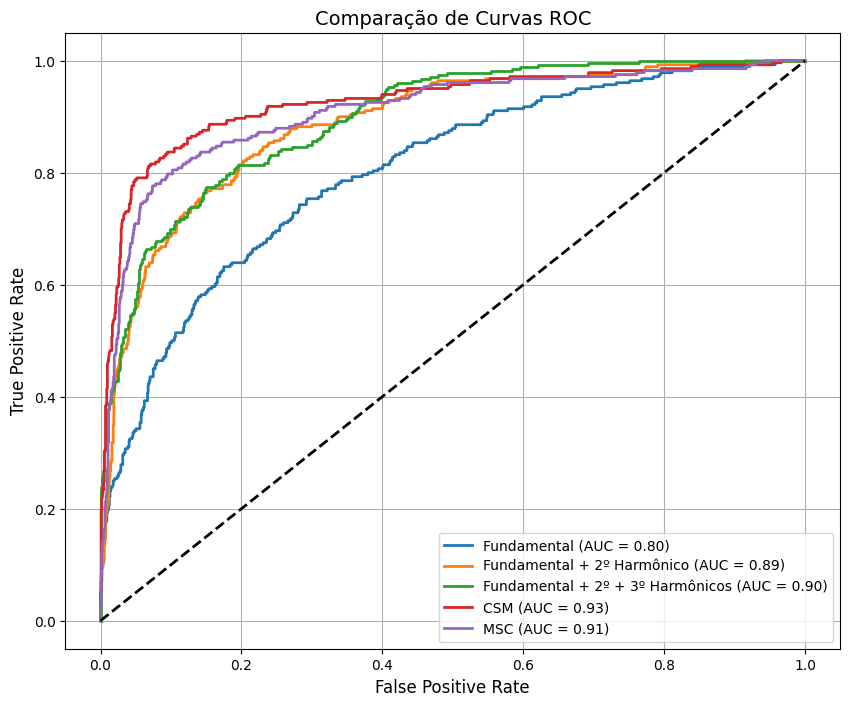

: 

In [ ]:
# Após o loop de avaliação dos datasets, adicione:
plot_all_roc_curves(results)